In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from simulation_utils import *
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, DistanceMetric, auc, f1_score, mutual_info_score
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
import scipy.stats as stat
from scipy.optimize import minimize
import itertools
# import ipyparallel as ipp
from collections import defaultdict
import pymc as pm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon
import matplotlib.animation as animation


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
np.set_printoptions(precision = 4, suppress = True)
sns.set_context('talk')
sns.set_style('darkgrid')

# Graph and walk set up

## 3-community structure

In [3]:
modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])
graph_distance_matrix = euclidean_distances(modular_graph/4)
# plot_graph(modular_graph, 'figures/modular_graph.png', boundary_color=False)
# plot_graph(modular_graph, 'figures/boundary_colored_modular_graph.png', boundary_color=True)
# plot_graph(create_adjacency_matrix_for_modular_graph(15, 0, [], [], [])+1, 'figures/unstructured_graph.png', boundary_color=True)
# plt.savefig('figures/modular_graph.png')

## Walk

<Axes: >

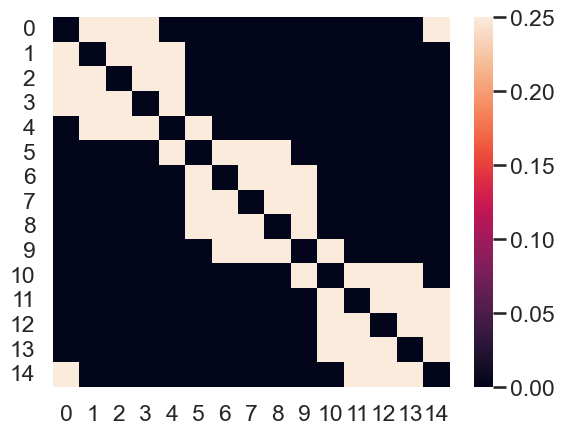

In [10]:
sns.heatmap(modular_graph/4)

In [4]:
walk_length = 1000
hop_step = walk_length
walk = random_walk(modular_graph, hop_step=hop_step, path_length=walk_length).astype(int)
hamiltonian_walk = np.array(hamiltonian_path(modular_graph, walk_length))

eular_walk = np.array(find_euler(modular_graph, 1000))

# Comparing SR and TCM Models


## Assessing full walk based differences

In [5]:
def find_best_params(model_func, graph_distance_matrix):
    curr_corr = 0
    for a in np.linspace(0.01, 0.99, 30):
        for b in np.linspace(0.01, 0.99, 30):
            if model_func == 'SR':
                model_output = run_SR(walk.astype(int), modular_graph,  a, b, plot = False)[0]
            else:
                model_output = run_tcm(walk.astype(int), modular_graph, a, b, plot = False)                
            model_output_distance_matrix = euclidean_distances(model_output)
            corr = stat.pearsonr(np.ravel(model_output_distance_matrix), np.ravel(graph_distance_matrix))[0]
            if np.abs(corr) > curr_corr:
                curr_corr = corr
                best_a = a
                best_b = b
    print(best_a, best_b)
    return best_a, best_b        
best_alpha_SR, best_gamma = find_best_params('SR', graph_distance_matrix)
best_alpha_TCM, best_beta = find_best_params('TCM', graph_distance_matrix)


0.04379310344827586 0.04379310344827586
0.04379310344827586 0.11137931034482758


### Plot SR and TCM for best fit params

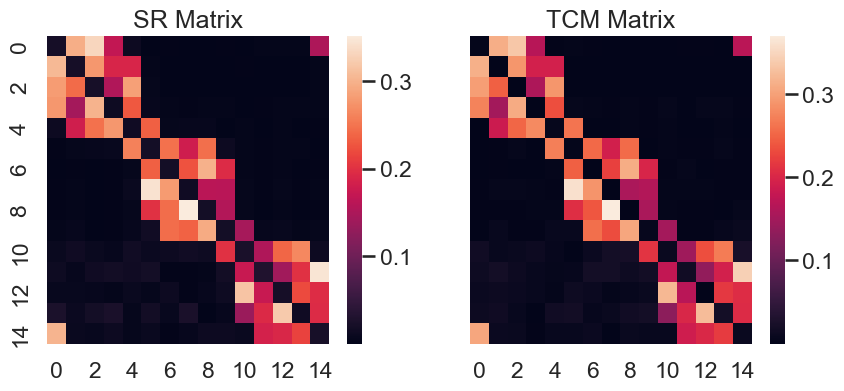

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize = (10, 4))
SR = run_SR(walk, alpha=best_alpha_SR, gamma=best_gamma, graph=modular_graph, plot = False)[0]
tcm = run_tcm(walk.astype(int), alpha=best_alpha_TCM, beta=best_beta, graph=modular_graph, plot = False)

# SR = run_SR(walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
# tcm = run_tcm(walk.astype(int), alpha=0.1, beta=0.1, graph=modular_graph, plot = False)

# print(SR)
ax[0].set_title('SR Matrix')
ax[1].set_title('TCM Matrix')
# ax[1][0].set_title('SR Dissimilarity Matrix')
# ax[1][1].set_title('TCM Dissimilarity Matrix')

sns.heatmap(SR, ax=ax[0])
sns.heatmap(tcm, ax=ax[1])
# js_SR = np.array([[jensenshannon(i, j) for i in SR] for j in SR]).reshape(15, 15)
# js_TCM = np.array([[jensenshannon(i, j) for i in tcm] for j in tcm]).reshape(15, 15)

# sns.heatmap(euclidean_distances(SR), ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(euclidean_distances(tcm), ax = ax[1][1], vmin = 0, vmax = 1)

# sns.heatmap(js_SR, ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(js_TCM, ax = ax[1][1], vmin = 0, vmax = 1)

plt.savefig('figures/SR_vs_TCM_Matrices.png', dpi = 300, transparent = True)

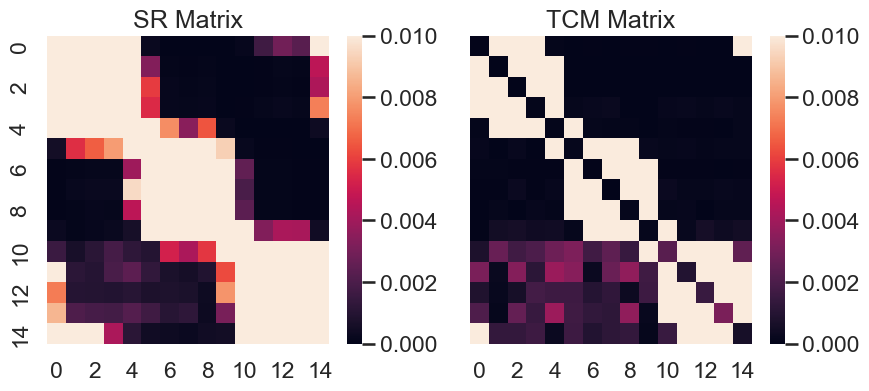

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize = (10, 4))
# SR = run_SR(walk, alpha=best_alpha_SR, gamma=best_gamma, graph=modular_graph, plot = False)
# tcm = run_tcm(walk.astype(int), alpha=best_alpha_TCM, beta=best_beta, graph=modular_graph, plot = False)

SR = run_SR(walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
tcm = run_tcm(walk.astype(int), alpha=0.1, beta=0.1, graph=modular_graph, plot = False)

# print(SR)
ax[0].set_title('SR Matrix')
ax[1].set_title('TCM Matrix')
# ax[1][0].set_title('SR Dissimilarity Matrix')
# ax[1][1].set_title('TCM Dissimilarity Matrix')

sns.heatmap(SR, ax=ax[0], vmin=0, vmax=0.01)
sns.heatmap(tcm, ax=ax[1], vmin=0, vmax=0.01)
# js_SR = np.array([[jensenshannon(i, j) for i in SR] for j in SR]).reshape(15, 15)
# js_TCM = np.array([[jensenshannon(i, j) for i in tcm] for j in tcm]).reshape(15, 15)

# sns.heatmap(euclidean_distances(SR), ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(euclidean_distances(tcm), ax = ax[1][1], vmin = 0, vmax = 1)

# sns.heatmap(js_SR, ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(js_TCM, ax = ax[1][1], vmin = 0, vmax = 1)

plt.savefig('figures/SR_vs_TCM_Matrices_zoomed.png', dpi = 300, transparent = True)

<Axes: title={'center': 'TCM Dissimilarity Matrix'}>

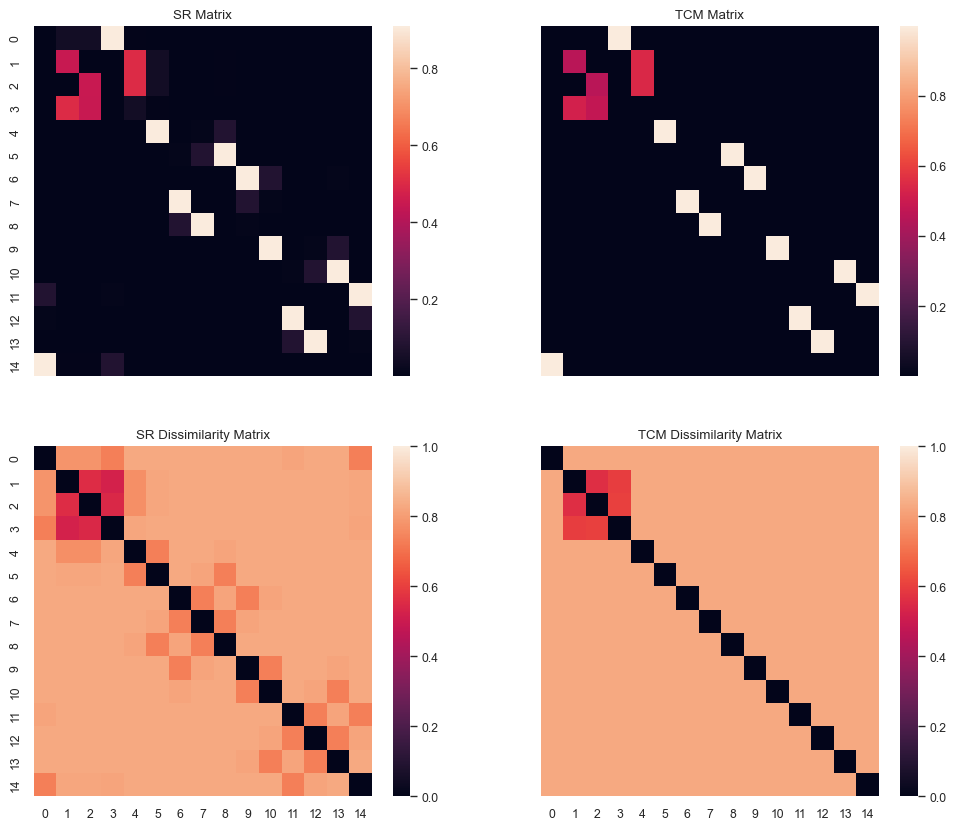

In [12]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize = (12, 10))
# SR = run_SR(walk, alpha=best_alpha_SR, gamma=best_gamma, graph=modular_graph, plot = False)
# tcm = run_tcm(walk.astype(int), alpha=best_alpha_TCM, beta=best_beta, graph=modular_graph, plot = False)

SR = run_SR(hamiltonian_walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
tcm = run_tcm(hamiltonian_walk.astype(int), alpha=0.1, beta=0.1, graph=modular_graph, plot = False)

# print(SR)
ax[0][0].set_title('SR Matrix')
ax[0][1].set_title('TCM Matrix')
ax[1][0].set_title('SR Dissimilarity Matrix')
ax[1][1].set_title('TCM Dissimilarity Matrix')

sns.heatmap(SR, ax=ax[0][0])
sns.heatmap(tcm, ax=ax[0][1])
js_SR = np.array([[jensenshannon(i, j) for i in SR] for j in SR]).reshape(15, 15)
js_TCM = np.array([[jensenshannon(i, j) for i in tcm] for j in tcm]).reshape(15, 15)

# sns.heatmap(euclidean_distances(SR), ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(euclidean_distances(tcm), ax = ax[1][1], vmin = 0, vmax = 1)

sns.heatmap(js_SR, ax = ax[1][0], vmin = 0, vmax = 1)
sns.heatmap(js_TCM, ax = ax[1][1], vmin = 0, vmax = 1)

# plt.savefig('figures/SR_vs_TCM_Matrices.png', transparent = True)

<Axes: title={'center': 'TCM Dissimilarity Matrix'}>

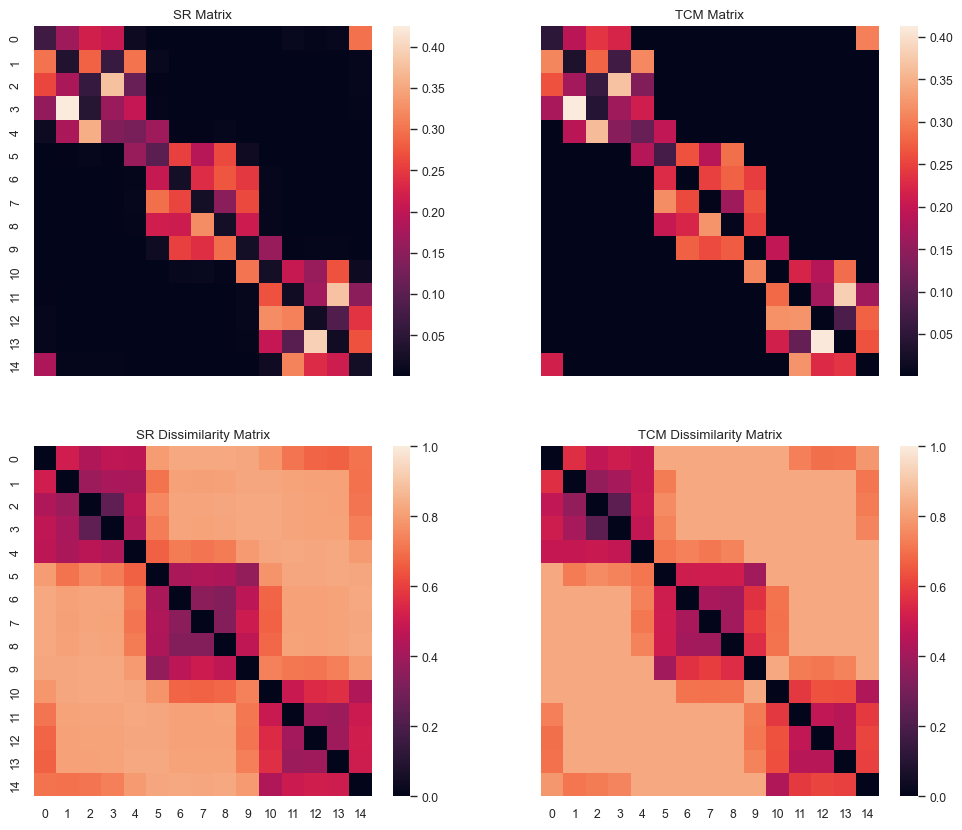

In [11]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize = (12, 10))
# SR = run_SR(walk, alpha=best_alpha_SR, gamma=best_gamma, graph=modular_graph, plot = False)
# tcm = run_tcm(walk.astype(int), alpha=best_alpha_TCM, beta=best_beta, graph=modular_graph, plot = False)

SR = run_SR(eular_walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
tcm = run_tcm(eular_walk.astype(int), alpha=0.1, beta=0.1, graph=modular_graph, plot = False)

# print(SR)
ax[0][0].set_title('SR Matrix')
ax[0][1].set_title('TCM Matrix')
ax[1][0].set_title('SR Dissimilarity Matrix')
ax[1][1].set_title('TCM Dissimilarity Matrix')

sns.heatmap(SR, ax=ax[0][0])
sns.heatmap(tcm, ax=ax[0][1])
js_SR = np.array([[jensenshannon(i, j) for i in SR] for j in SR]).reshape(15, 15)
js_TCM = np.array([[jensenshannon(i, j) for i in tcm] for j in tcm]).reshape(15, 15)

# sns.heatmap(euclidean_distances(SR), ax = ax[1][0], vmin = 0, vmax = 1)
# sns.heatmap(euclidean_distances(tcm), ax = ax[1][1], vmin = 0, vmax = 1)

sns.heatmap(js_SR, ax = ax[1][0], vmin = 0, vmax = 1)
sns.heatmap(js_TCM, ax = ax[1][1], vmin = 0, vmax = 1)

# plt.savefig('figures/SR_vs_TCM_Matrices.png', transparent = True)

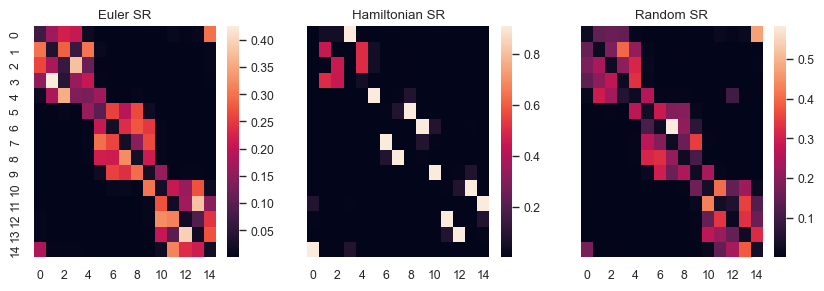

In [21]:
euler_SR = run_SR(eular_walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
hamiltonian_SR = run_SR(hamiltonian_walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
random_SR = run_SR(walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 3))
sns.heatmap(euler_SR, ax=ax[0])
sns.heatmap(hamiltonian_SR, ax=ax[1])
sns.heatmap(random_SR, ax=ax[2])
ax[0].set_title('Euler SR')
ax[1].set_title('Hamiltonian SR')
ax[2].set_title('Random SR')
plt.savefig('figures/three_walk_model_simulations.png', dpi = 300, transparent = True)


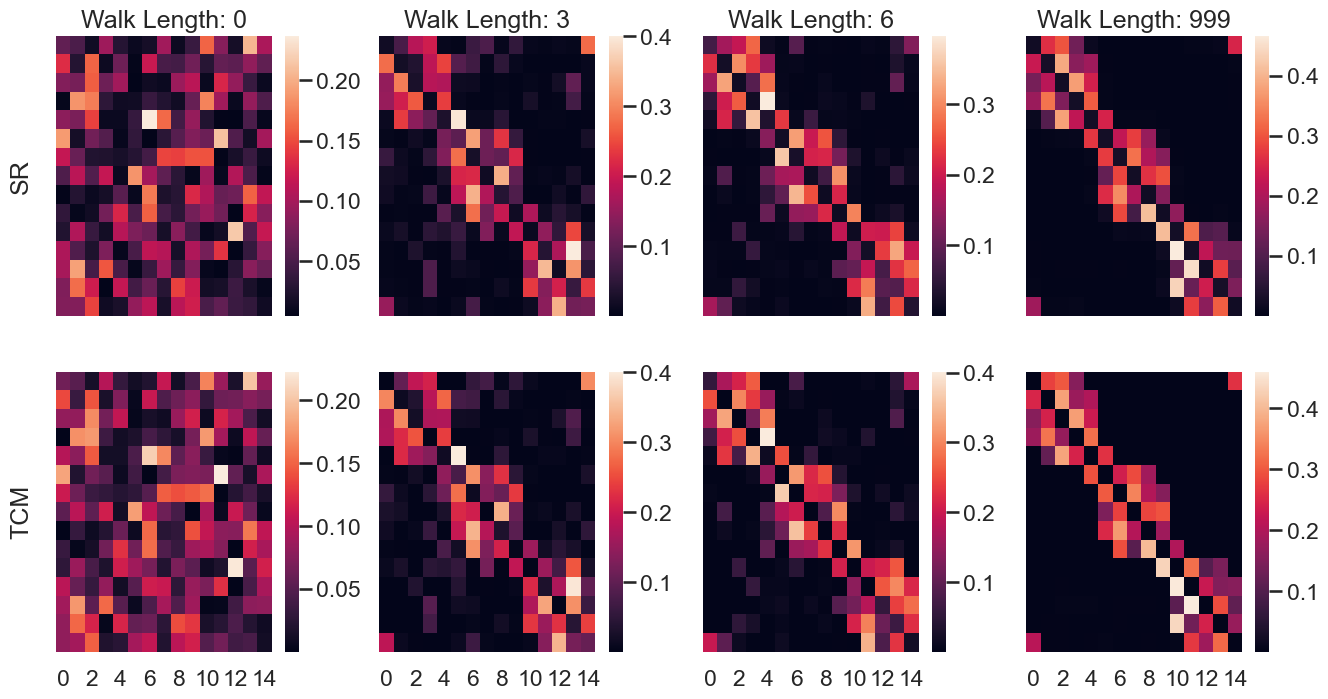

In [185]:

walk_lengths = [1, 4, 7, 1000]
fig, ax = plt.subplots(2, len(walk_lengths), sharex=True, sharey=True, figsize = (16, 8))

for i, walk_length in enumerate(walk_lengths):

    walk = random_walk(modular_graph, hop_step=walk_length, path_length=1000).astype(int)

    random_SR = run_SR(walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)[0]
    random_TCM = run_tcm(walk, alpha=0.1, beta=0.1, graph=modular_graph, plot=False)

    sns.heatmap(random_SR, ax=ax[0][i])
    sns.heatmap(random_TCM, ax=ax[1][i])

    ax[0][i].set_title(f'Walk Length: {walk_length-1}')
    ax[0][i].set_yticklabels([])
    ax[0][0].set_ylabel('SR')
    ax[1][0].set_ylabel('TCM')

plt.savefig('figures/walk_length_SR_TCM_matrices.png', dpi = 300, transparent = True)


In [ ]:
nonb_nonb_idx = [i for i in itertools.combinations([1, 2, 3], 2)] + [i for i in itertools.combinations([6, 7, 8], 2)] + [i for i in itertools.combinations([11, 12, 13], 2)]
nonb_b_idx = [i for i in itertools.product([0, 4], [1, 2, 3])] + [i for i in itertools.product([5, 9], [6, 7, 8])] + [i for i in itertools.product([10, 14], [11, 12, 13])]

nonb_nonb_js = np.mean([js_SR[i] for i in nonb_nonb_idx])
nonb_b_js = np.mean([js_SR[i] for i in nonb_b_idx])
b_b_js = np.mean([js_SR[i] for i in [(0, 14), (4, 5), (9, 10)]])


In [ ]:
nonb_nonb_js, nonb_b_js, b_b_js

(0.3407622661137921, 0.5190504522967724, 0.7238003698672908)

In [ ]:
nonb_nonb_js = np.mean([js_TCM[i] for i in nonb_nonb_idx])
nonb_b_js = np.mean([js_TCM[i] for i in nonb_b_idx])
b_b_js = np.mean([js_TCM[i] for i in [(0, 14), (4, 5), (9, 10)]])
nonb_nonb_js, nonb_b_js, b_b_js

(0.4205335055596334, 0.6062096295544264, 0.8267016181432205)

In [ ]:
np.where(modular_graph==1)

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 14, 14, 14, 14], dtype=int64),
 array([ 1,  2,  3, 14,  0,  2,  3,  4,  0,  1,  3,  4,  0,  1,  2,  4,  1,
         2,  3,  5,  4,  6,  7,  8,  5,  7,  8,  9,  5,  6,  8,  9,  5,  6,
         7,  9,  6,  7,  8, 10,  9, 11, 12, 13, 10, 12, 13, 14, 10, 11, 13,
        14, 10, 11, 12, 14,  0, 11, 12, 13], dtype=int64))

### MDS visualization

Text(0.5, 1.0, 'TCM MDS Space')

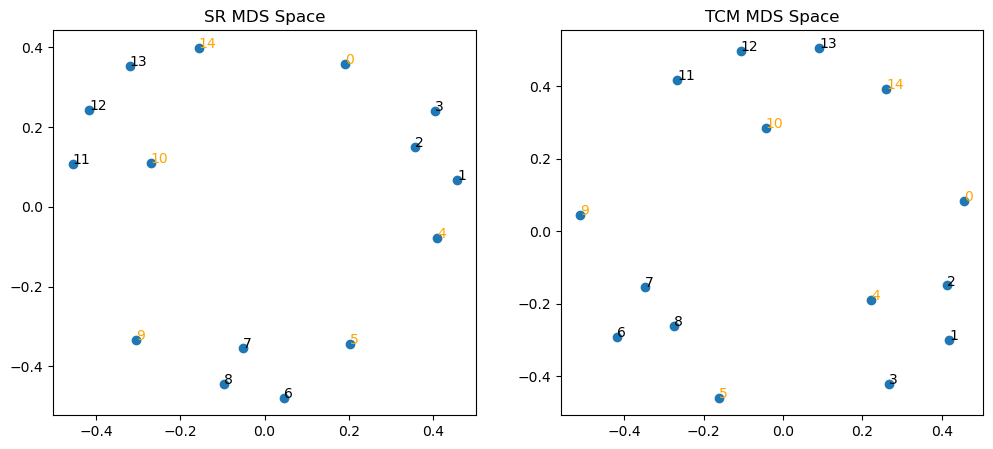

In [ ]:
#| label: fig-SRvsTCM-mdscomp
#| fig-cap: > 
#|     Comparing MDS spaces based on the best-fit model outputs. Boundary nodes are marked in Orange 

embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed')
# SR_transformed = embedding.fit_transform(euclidean_distances(SR))
# tcm_transformed = embedding.fit_transform(euclidean_distances(tcm))
SR_transformed = embedding.fit_transform(js_SR)
tcm_transformed = embedding.fit_transform(js_TCM)

fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].scatter(SR_transformed[:, 0], SR_transformed[:, 1])
ax[1].scatter(tcm_transformed[:, 0], tcm_transformed[:, 1])

for i in range(15):
    if i in [0, 4, 5, 9, 10, 14]:
        color = 'orange'
    else:
        color = 'black'
    ax[0].annotate(i, (SR_transformed[i, 0], SR_transformed[i, 1]), color=color)
    ax[1].annotate(i, (tcm_transformed[i, 0], tcm_transformed[i, 1]), color=color)
ax[0].set_title('SR MDS Space')
ax[1].set_title('TCM MDS Space')


## Comparing Entropy based walk-length differences between models

In [50]:
#Reformat the dataframe to long format, label nodes, and rename parameters

# df = pd.read_csv('simulation_results/3module_SRTCM_entropies.csv').drop(['Unnamed: 0'], axis = 1)
# df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm.csv').drop(['Unnamed: 0'], axis = 1)
df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm_vertical.csv')

df['node_type'] = 'nonboundary'
df.loc[df['node'].isin([0, 4, 5, 9, 10, 14]), 'node_type'] = 'boundary'
df_grouped = df.groupby(['iteration', 'param_a', 'param_b', 'walk_length', 'model', 'node_type']).mean().reset_index()
df_boundary = df_grouped.loc[df_grouped['node_type'] == 'boundary'].reset_index(drop=True)
df_nonboundary = df_grouped.loc[df_grouped['node_type'] == 'nonboundary'].reset_index(drop=True)

df_diff = df_boundary
df_diff['entropy_difference'] = df_boundary['entropy'] - df_nonboundary['entropy']
df_diff = df_diff.drop(['entropy', 'node_type'], axis = 1)

# df_melt = df.melt(id_vars=['iteration', 'walk_length', 'model', 'node', 'node_type', 'entropy'], value_name='param value', var_name='param')
# df_melt.loc[((df_melt['model'] == 'SR') & (df_melt['param'] == 'param_a')), 'param'] = 'alpha'
# df_melt.loc[((df_melt['model'] == 'SR') & (df_melt['param'] == 'param_b')), 'param'] = 'gamma'
# df_melt.loc[((df_melt['model'] == 'TCM') & (df_melt['param'] == 'param_a')), 'param'] = 'alpha'
# df_melt.loc[((df_melt['model'] == 'TCM') & (df_melt['param'] == 'param_b')), 'param'] = 'beta'


In [131]:
param_combo = itertools.product(np.arange(20), [0.01, 0.1, 0.25, 0.5, 0.7, 0.9], [0.01, 0.1, 0.25, 0.5, 0.7, 0.9], [1, 4, 7, 1000])
model_params = [m for m in param_combo]


In [133]:
SR_entropies = np.array([compute_node_entropies([model_params[i][0], model_params[i][1], model_params[i][2], model_params[i][3], modular_graph, 'SR']) 
                      for i in range(len(model_params))])

In [135]:
TCM_entropies = np.array([compute_node_entropies([model_params[i][0], model_params[i][1], model_params[i][2], model_params[i][3], modular_graph, 'TCM']) 
                      for i in range(len(model_params))])

In [53]:
# entropy_df = pd.DataFrame({'Model': np.repeat(['SR', 'TCM'], TCM_entropies.shape[0]*TCM_entropies.shape[1]),
#                            'entropy': np.concatenate((np.ravel(SR_entropies), np.ravel(TCM_entropies))),
#                            'iterations': np.tile(np.repeat(np.array(model_params)[:, 0], 15), 2),
#                            'param_a': np.tile(np.repeat(np.array(model_params)[:, 1], 15), 2),
#                            'param_b': np.tile(np.repeat(np.array(model_params)[:, 2], 15), 2),
#                            'walk length': np.tile(np.repeat(np.array(model_params)[:, 3], 15), 2),
#                            'nodes': np.tile(np.arange(15), TCM_entropies.shape[0]*2)

# })

entropy_df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm_vertical.csv')

entropy_df['node_type'] = 'nonboundary'
entropy_df.loc[entropy_df['node'].isin([0, 4, 5, 9, 10, 14]), 'node_type'] = 'boundary'

In [56]:
grouped_entropy_df = entropy_df.groupby(['model', 'iteration', 'param_a', 'param_b', 'node_type', 'walk_length']).mean().reset_index()
boundary_entropy_df = grouped_entropy_df.loc[grouped_entropy_df.node_type == 'boundary'].reset_index(drop=True)
nonboundary_entropy_df = grouped_entropy_df.loc[grouped_entropy_df.node_type == 'nonboundary'].reset_index(drop=True)



In [59]:
entropy_diff = pd.merge(left=boundary_entropy_df, right=nonboundary_entropy_df,
                        left_on = ['model', 'iteration', 'param_a', 'param_b', 'walk_length'], 
                        right_on = ['model', 'iteration', 'param_a', 'param_b', 'walk_length'],
                        
                        )
entropy_diff['diff'] = entropy_diff['entropy_x'] - entropy_diff['entropy_y']
# entropy_diff['walk length'] = (entropy_diff['walk length'] - 1).astype(int)


In [152]:
entropy_diff.to_csv('simulation_results/SR_TCM_walklength_boundary_nonboundary_entropydiff.csv')

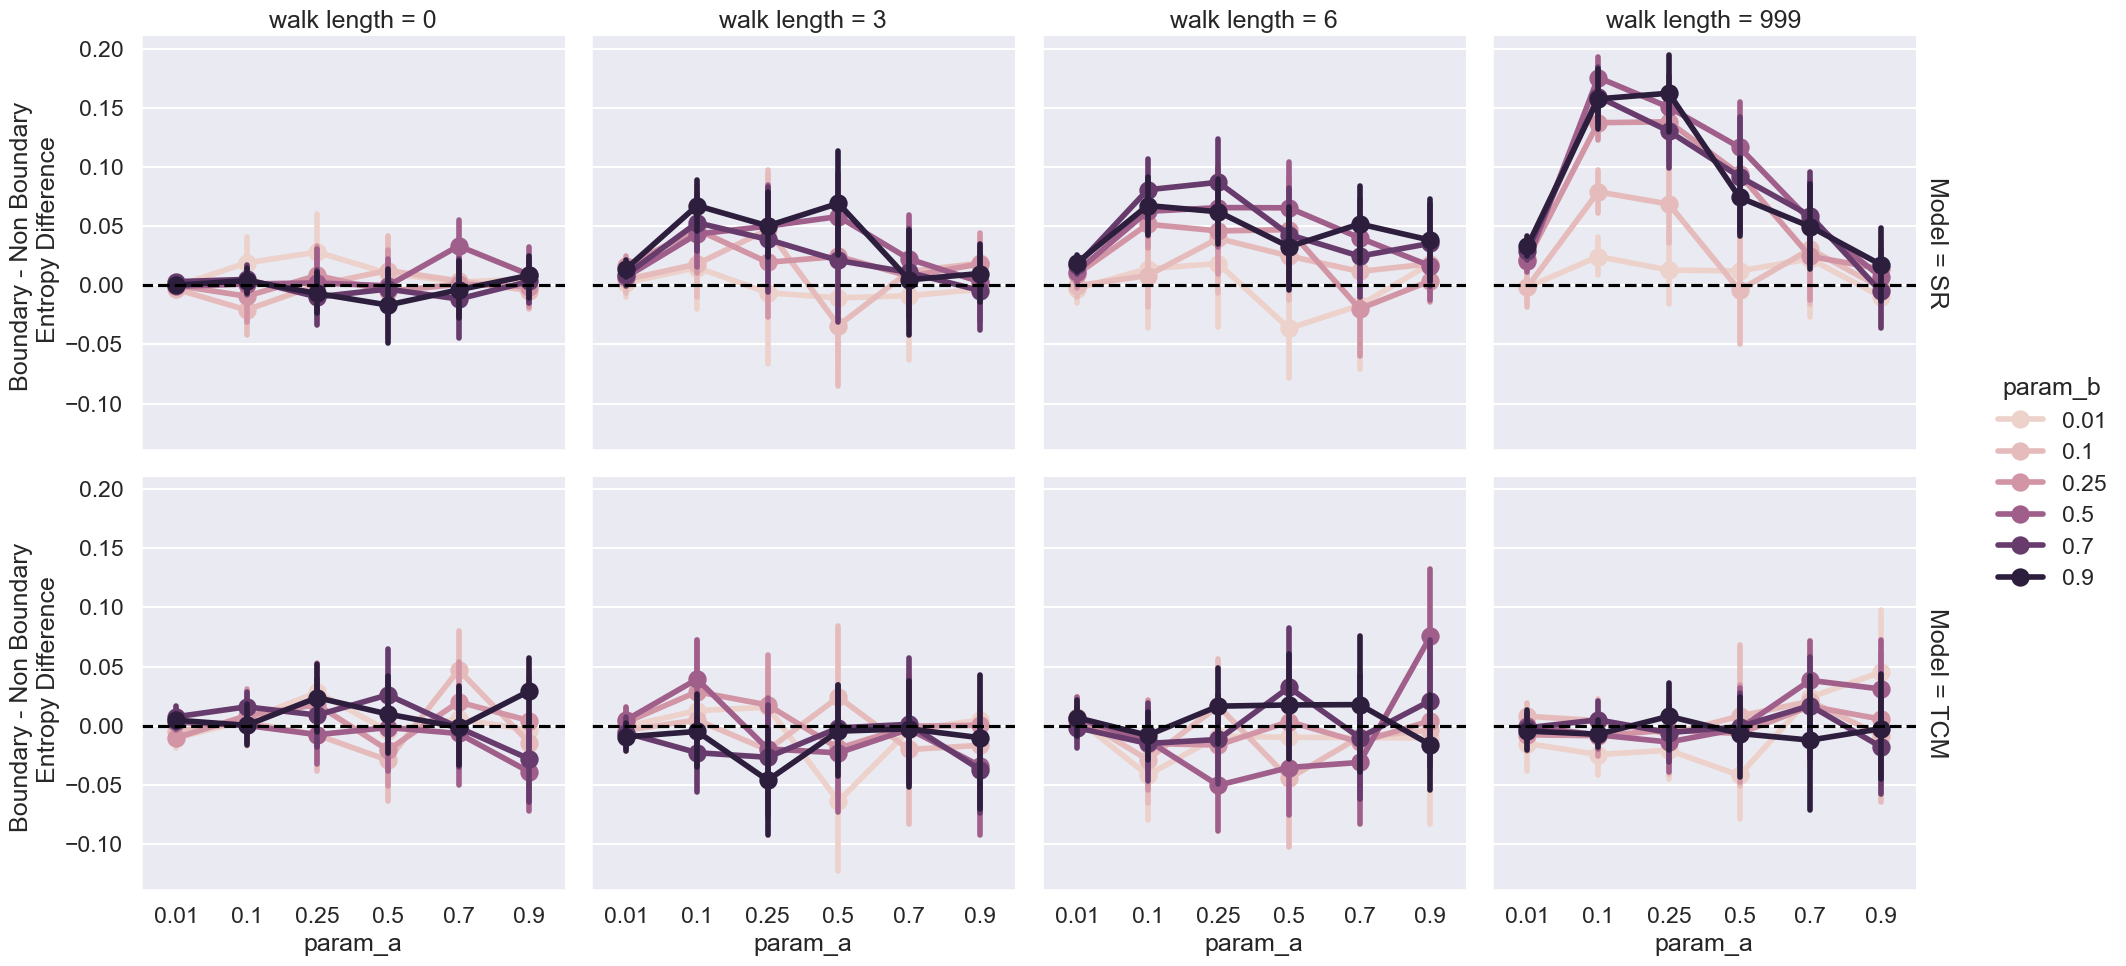

In [153]:
g = sns.catplot(y = 'diff', 
                x = 'param_a',  hue = 'param_b', col = 'walk length', row = 'Model', 
                data = entropy_diff, 
                kind = 'point', margin_titles = True)
for i in range(2):
    for j in range(4):
        g.axes[i][j].axhline(y = 0, ls = '--', color = 'black')
g.set_ylabels('Boundary - Non Boundary \n Entropy Difference')
plt.savefig('figures/SR_TCM_walklength_boundary_nonboundary_entropydiff.png', dpi = 300, transparent = True)


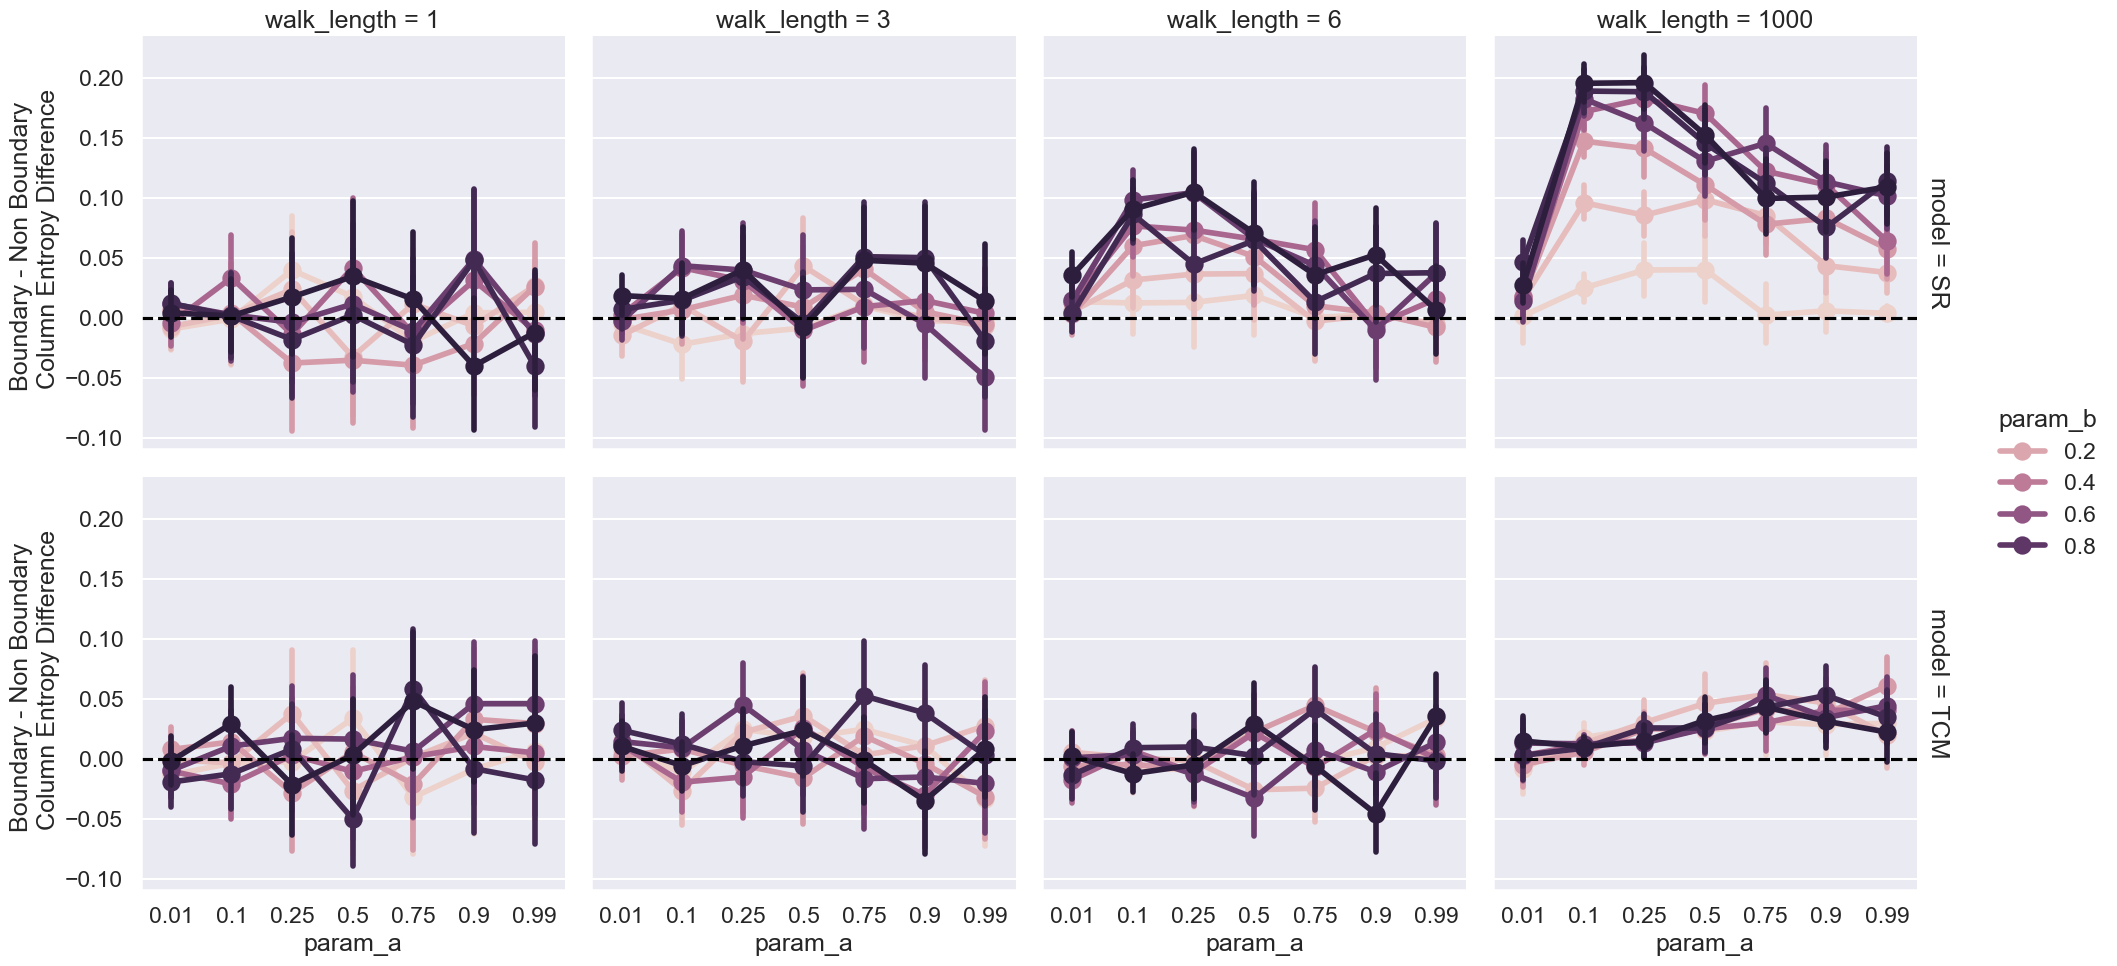

In [64]:
g = sns.catplot(y = 'diff', 
                x = 'param_a',  hue = 'param_b', col = 'walk_length', row = 'model', 
                data = entropy_diff, 
                kind = 'point', margin_titles = True)
for i in range(2):
    for j in range(4):
        g.axes[i][j].axhline(y = 0, ls = '--', color = 'black')
g.set_ylabels('Boundary - Non Boundary \n Column Entropy Difference')
plt.savefig('figures/SR_TCM_walklength_boundary_nonboundary_entropydiff_vertical.png', dpi = 300, transparent = True)


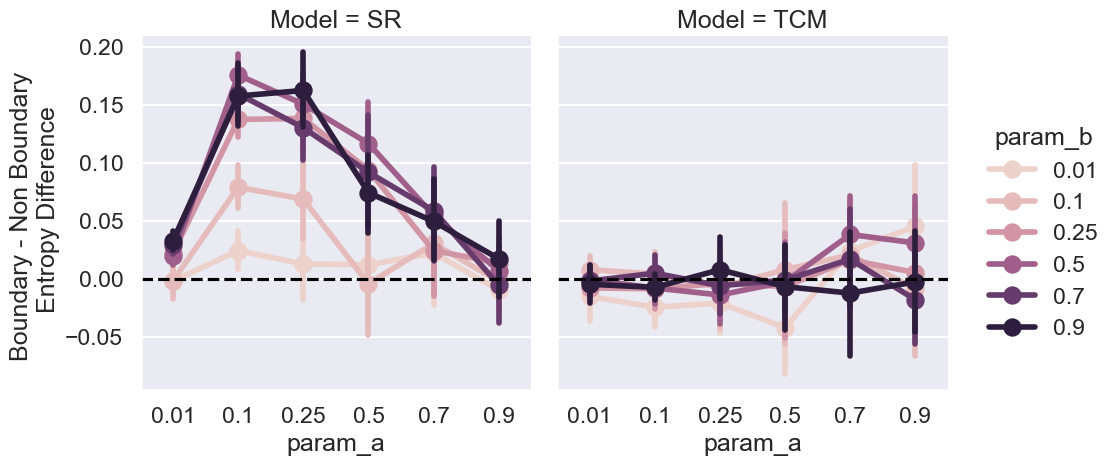

In [10]:
entropy_diff = pd.read_csv('simulation_results/SR_TCM_walklength_boundary_nonboundary_entropydiff.csv')
g = sns.catplot(y = 'diff', 
                x = 'param_a',  hue = 'param_b', col = 'Model', 
                data = entropy_diff.loc[entropy_diff['walk length'] == 999], 
                kind = 'point', margin_titles = True)
for i in range(2):
    g.axes[0][i].axhline(y = 0, ls = '--', color = 'black')
g.set_ylabels('Boundary - Non Boundary \n Entropy Difference')
plt.savefig('figures/SR_TCM_walklength_boundary_nonboundary_entropydiff_longestwalk.png', dpi = 300, transparent = True)


In [22]:
surprisal_df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm_surprisal.csv')
# entropy_diff = pd.merge(left=boundary_entropy_df, right=nonboundary_entropy_df,
#                         left_on = ['Model', 'iterations', 'param_a', 'param_b', 'walk length'], 
#                         right_on = ['Model', 'iterations', 'param_a', 'param_b', 'walk length'],
                        
#                         )
# entropy_diff['diff'] = entropy_diff['entropy_x'] - entropy_diff['entropy_y']
# entropy_diff['walk length'] = (entropy_diff['walk length'] - 1).astype(int)

# g = sns.catplot(y = 'diff', 
#                 x = 'param_a',  hue = 'param_b', col = 'Model', 
#                 data = entropy_diff.loc[entropy_diff['walk length'] == 999], 
#                 kind = 'point', margin_titles = True)
# for i in range(2):
#     g.axes[0][i].axhline(y = 0, ls = '--', color = 'black')
# g.set_ylabels('Boundary - Non Boundary \n Entropy Difference')
# # plt.savefig('figures/SR_TCM_walklength_boundary_nonboundary_entropydiff_longestwalk.png', dpi = 300, transparent = True)


In [43]:
surprisal_df['transition type'] = 'cross cluster'
surprisal_df.loc[surprisal_df['node comp'] != 'bb', 'transition type'] = 'within cluster'


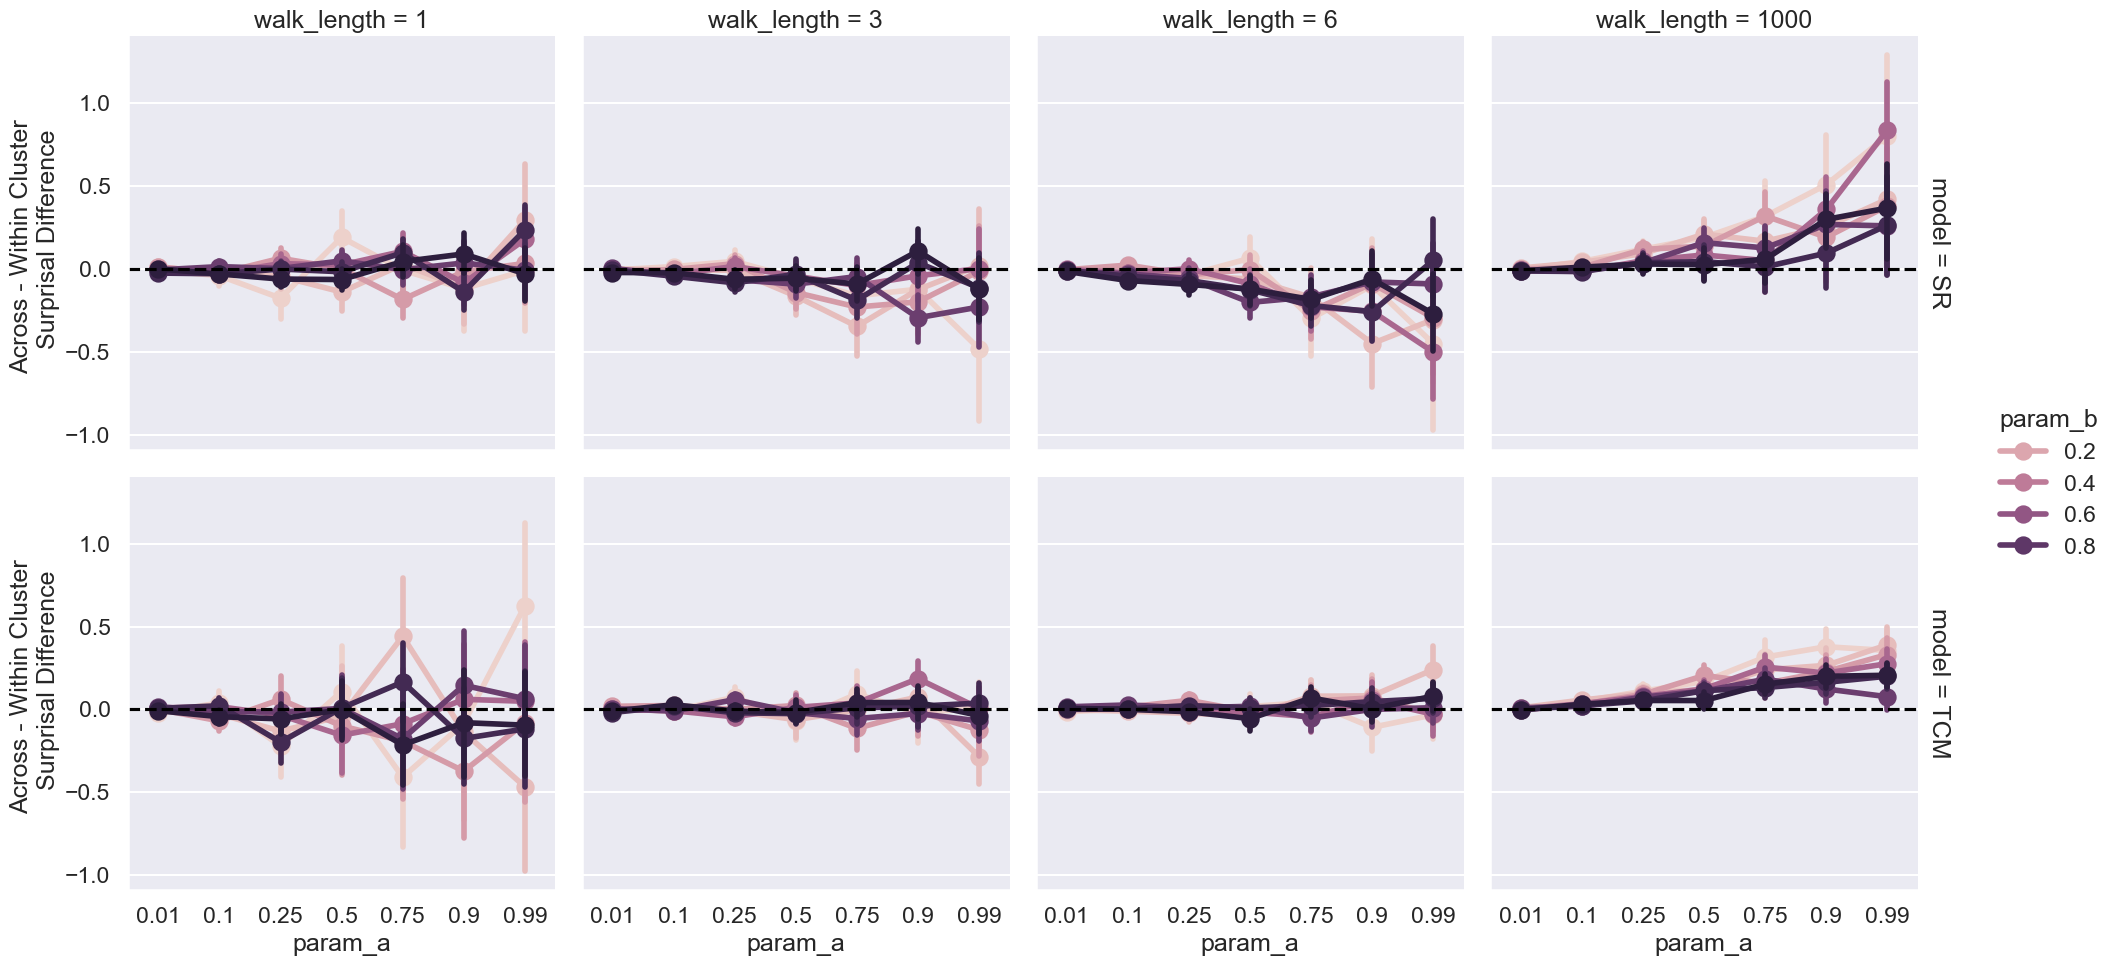

In [48]:
surprisal_df_across = surprisal_df.loc[surprisal_df['transition type'] == 'cross cluster'].reset_index(drop=True)
surprisal_df_within = surprisal_df.loc[surprisal_df['transition type'] == 'within cluster'].reset_index(drop=True)
# surprisal_df_nbb
entropy_diff = pd.merge(left=surprisal_df_across, right=surprisal_df_within,
                        left_on = ['model', 'iteration', 'param_a', 'param_b', 'walk_length'], 
                        right_on = ['model', 'iteration', 'param_a', 'param_b', 'walk_length'],
                        
                        )
entropy_diff['diff'] = entropy_diff['entropy_x'] - entropy_diff['entropy_y']
# entropy_diff
g = sns.catplot(y = 'diff', 
                x = 'param_a',  hue = 'param_b', col = 'walk_length', row = 'model', 
                data = entropy_diff, 
                kind = 'point', margin_titles = True)
for i in range(2):
    for j in range(4):
        g.axes[i][j].axhline(y = 0, ls = '--', color = 'black')
g.set_ylabels('Across - Within Cluster \n Surprisal Difference')
plt.savefig('figures/SR_TCM_walklength_boundary_nonboundary_surprisaldiff.png', dpi = 300, transparent = True)


,Unnamed: 0_x,iteration,param_a,param_b,walk_length,model,node comp_x,entropy_x,Unnamed: 0_y,node comp_y,entropy_y
0,1,0,0.01,0.01,1,SR,nbb,2.773275,0,nbnb,3.164118
1,5,0,0.01,0.01,1,TCM,nbb,2.959253,4,nbnb,2.677722
2,9,0,0.01,0.01,3,SR,nbb,2.122059,8,nbnb,1.967226
3,13,0,0.01,0.01,3,TCM,nbb,2.123022,12,nbnb,1.987034
4,17,0,0.01,0.01,6,SR,nbb,2.086730,16,nbnb,1.894041
...,...,...,...,...,...,...,...,...,...,...,...
39195,156781,99,0.99,0.99,3,TCM,nbb,1.716408,156780,nbnb,3.428408
39196,156785,99,0.99,0.99,6,SR,nbb,4.929068,156784,nbnb,4.045556
39197,156789,99,0.99,0.99,6,TCM,nbb,2.054792,156788,nbnb,2.204034
39198,156793,99,0.99,0.99,1000,SR,nbb,2.998404,156792,nbnb,3.163121


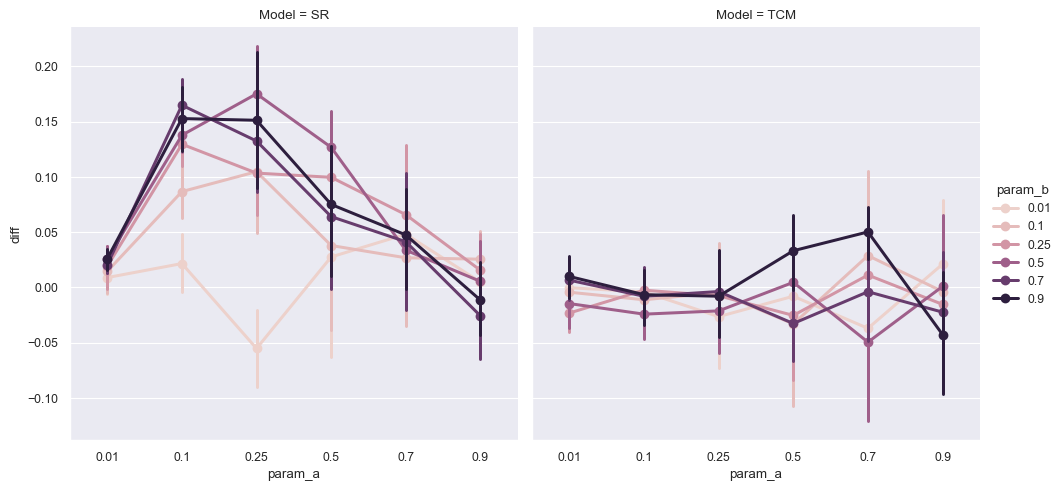

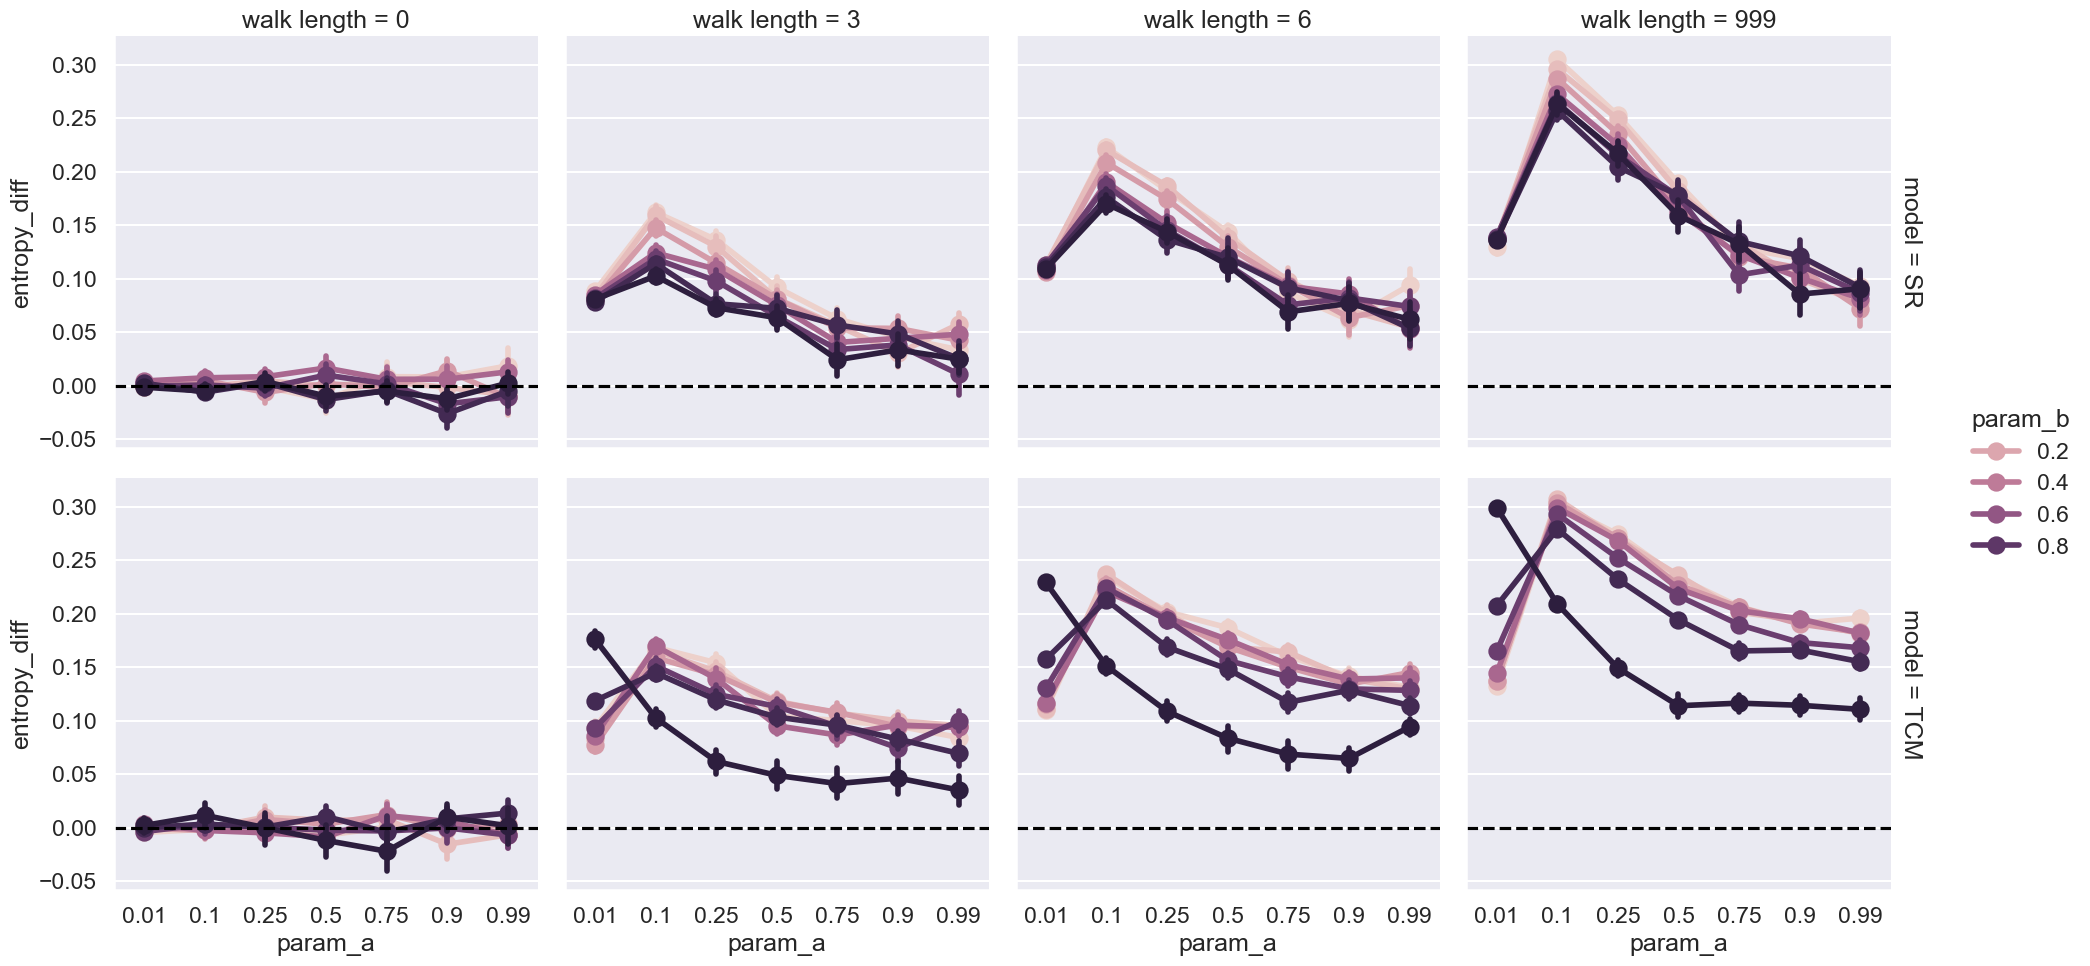

In [9]:
df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm_sjdist.csv').drop(['Unnamed: 0'], axis = 1)
df_bb = df.loc[df['node comp'] == 'bb'].reset_index(drop=True)
df_nonbb = df.loc[df['node comp'] != 'bb'].reset_index(drop=True).groupby(['iteration', 'param_a', 'param_b', 'walk_length', 'model']).mean(numeric_only=True).reset_index(drop=True)

# df_nonboundary = df_grouped.loc[df_grouped['node_type'] == 'nonboundary'].reset_index(drop=True)
df_bb['entropy_diff'] = df_bb['entropy']-df_nonbb['entropy']
g = sns.catplot(x = 'param_a', y = 'entropy_diff', hue = 'param_b', row = 'model', col = 'walk_length',
                data = df_bb, kind = 'point', margin_titles=True,
                # hue_order = df['param_b'].unique()
               )

ax = g.axes
for i in np.ravel(ax):
    i.axhline(y = 0, color = 'black', ls = '--')
ax[0][0].set_title('walk length = 0')
ax[0][1].set_title('walk length = 3')
ax[0][2].set_title('walk length = 6')
ax[0][3].set_title('walk length = 999')


plt.savefig('figures/SR_TCM_boundary_nonboundary_jsdist.png', transparent = True, dpi = 300)

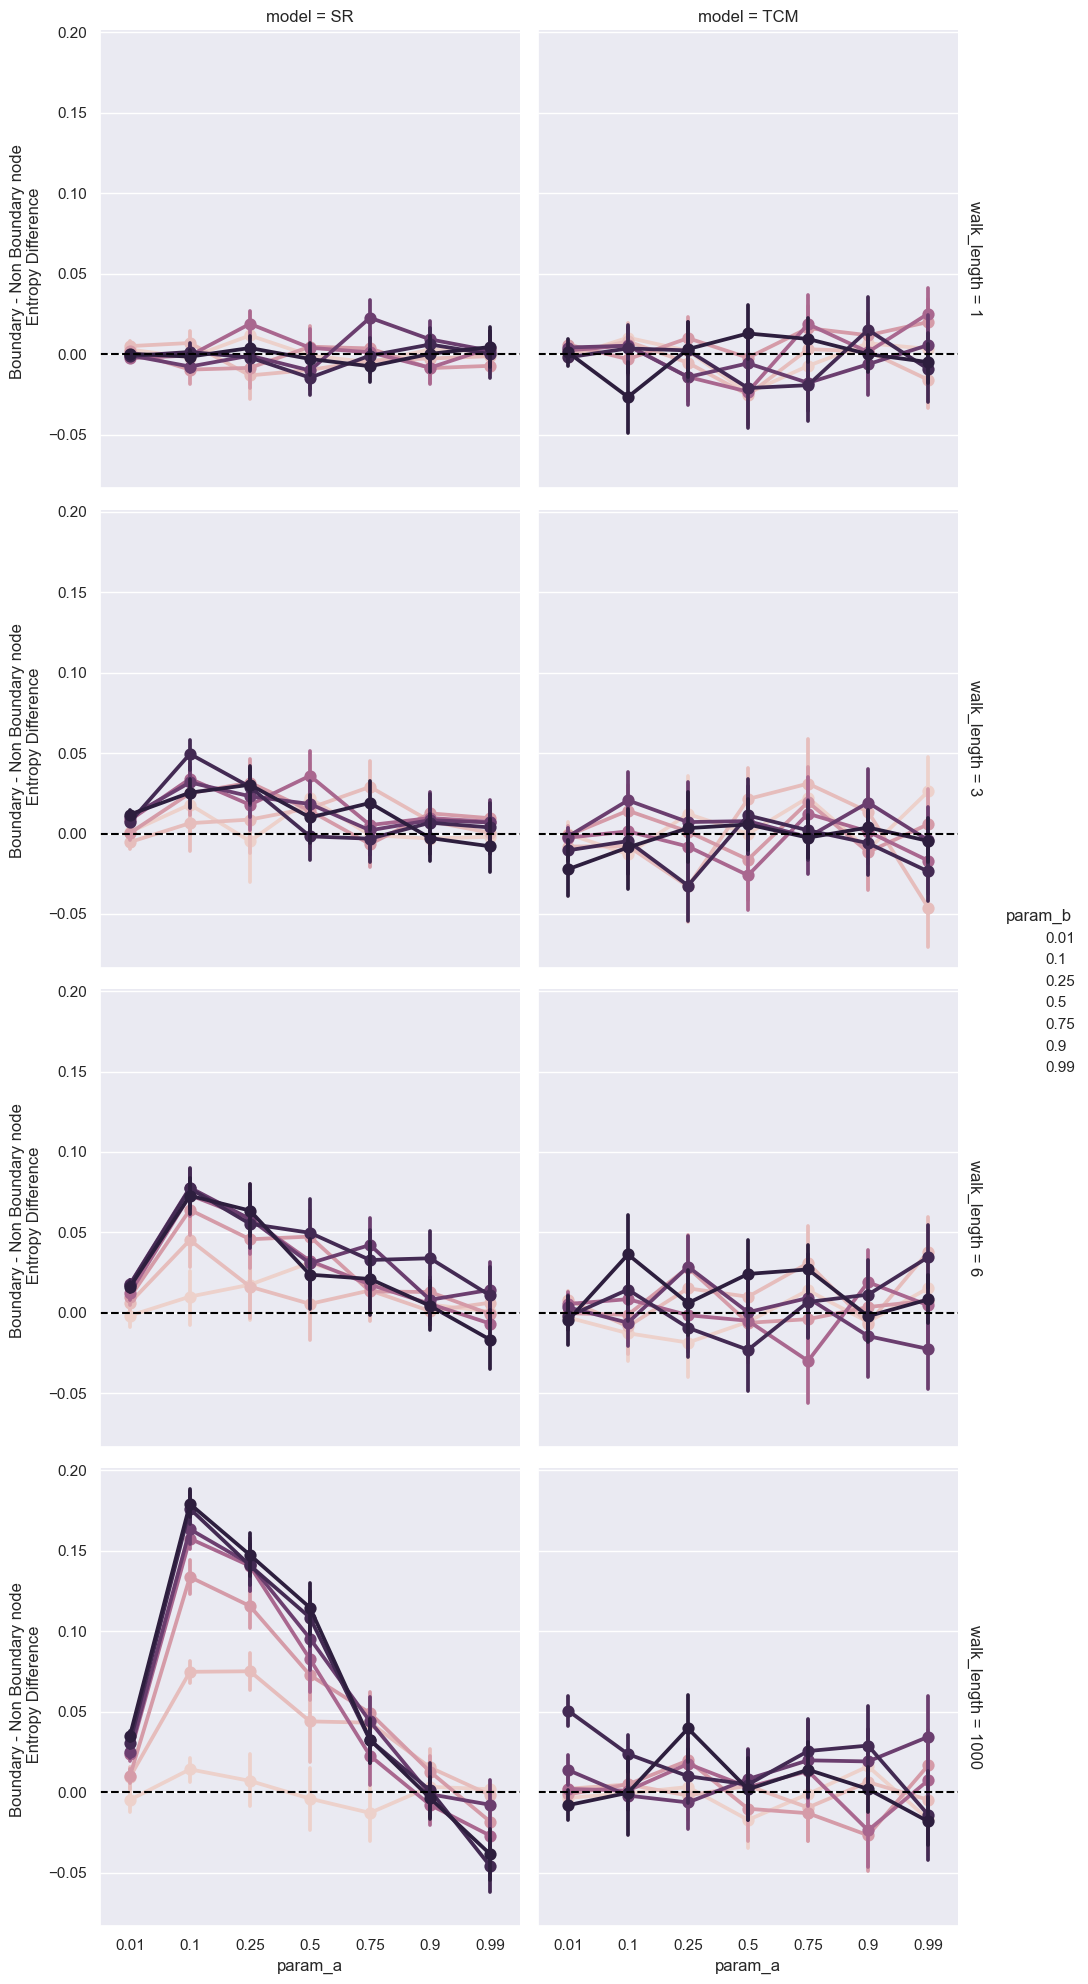

In [ ]:
#| label: fig-walk-length-model-prediction-differences
#| fig-cap: > 
#|    The SR model predicts (Top Panels) that as walk length increases, the difference in entropy between boundary and the non boundary nodes also increases
#|    On the other hand, no such increase in difference is predicted by the CMR model (Bottom Panel). 
sns.set_context("talk")
sns.set_theme()
g = sns.catplot(x = 'param_a', y = 'entropy_difference', hue = 'param_b', col = 'model', row = 'walk_length',
                data = df_diff, kind = 'point', margin_titles=True,
                hue_order = df_diff['param_b'].unique()
               )
ax = g.axes
for i in np.ravel(ax):
    i.axhline(y = 0, color = 'black', ls = '--')

g.set_ylabels('Boundary - Non Boundary node \n Entropy Difference')

# Testing Implicit Event Boundary differences from Explicit ones

## Distance between nodes

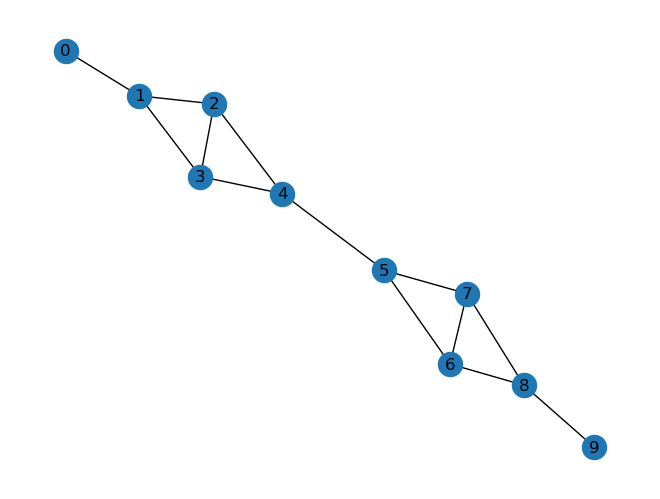

In [ ]:
#### | label: fig-distance-graph-structure
#| fig-cap: > 
#|    The temporal community structure to be used in distance judgement tasks
two_module_dist_graph = create_adjacency_matrix_for_modular_graph(10, 2, [5, 5], [(4, 5)], [4, 5], 
                                                                  [(0, 4), (4, 1), (0, 2), (0, 3), 
                                                                   (9, 5), (5, 8), (6, 9), (7, 9)                                                             
                                                                  ])

plot_graph(two_module_dist_graph)


NameError: name 'two_module_dist_graph' is not defined

In [ ]:
all_comb = np.array([i for i in itertools.permutations(np.arange(10), 3)])
critical = np.array([(4, 3, 5), (4, 2, 5), (5, 4, 6), (5, 7, 6), (4, 1, 7), (4, 1, 6), (5, 8, 2), (5, 8, 3), (4, 0, 8), (5, 9, 1)])
crit_indices = np.array([np.where((all_comb == c).all(1))[0][0] for c in critical])
rest_indices = np.delete(np.arange(np.shape(all_comb)[0]), crit_indices)
filler_indices = np.random.choice(rest_indices, 10)

test_indices = np.concatenate((crit_indices, filler_indices))
test_indices_labels = np.repeat(['critical', 'filler'], 10)
test_indices_idx = np.arange(test_indices.shape[0])
np.random.shuffle(test_indices_idx)
test_indices = test_indices[test_indices_idx]
test_indices_labels = test_indices_labels[test_indices_idx]

In [ ]:
test_parent_child_idx = all_comb[test_indices]

In [ ]:
parent_idx = test_parent_child_idx[:, 0]

In [ ]:
child_idx = test_parent_child_idx[:, 1:]

In [ ]:
paths = np.array(["asb/1oi", "aosi/nwi", "Asjknd/dkjf"])

In [ ]:
def dijkstra(graph, start):
    # Initialize distance array
    distance = [np.inf] * len(graph)
    distance[start] = 0
    # Array to track visited nodes
    visited = [False] * len(graph)

    for _ in range(len(graph)):
        # Find the vertex with the minimum distance
        min_distance = np.inf
        min_index = -1
        for v in range(len(graph)):
            if not visited[v] and distance[v] < min_distance:
                min_distance = distance[v]
                min_index = v
        
        # Mark the minimum distance vertex as visited
        visited[min_index] = True
        
        # Update distance values of adjacent vertices
        for v in range(len(graph)):
            if not visited[v] and graph[min_index][v] > 0 and distance[min_index] + graph[min_index][v] < distance[v]:
                distance[v] = distance[min_index] + graph[min_index][v]
    
    return distance

def shortest_distance(graph, start, end):
    # Use Dijkstra's algorithm to find shortest distances from the start node
    distances = dijkstra(graph, start)
    return distances[end]


In [ ]:
shortest_distance(two_module_dist_graph, 0, 9)

7.0

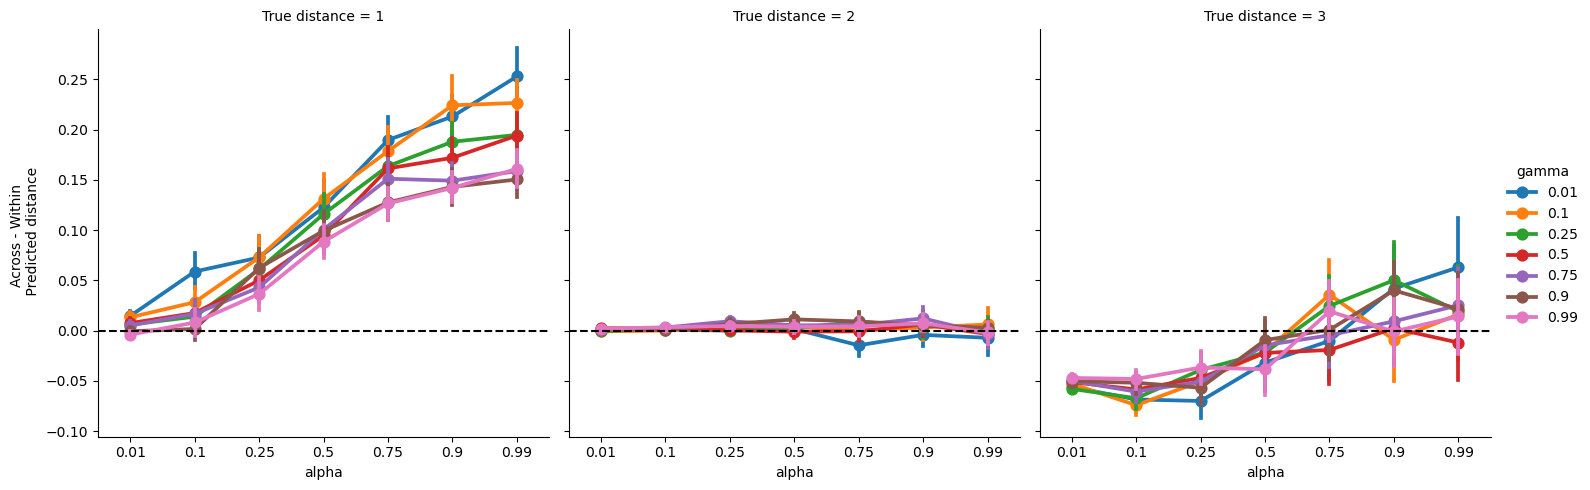

In [ ]:
#| label: fig-distance-judgement-predictions
#| fig-cap: > 
#|    Model Predictions for distance judgment task.
distances = pd.read_csv('simulation_results/2moduledist_SR_distances.csv').drop(['Unnamed: 0', "walk_length", "model", "node"], axis = 1)
distances.rename(columns={"entropy distance (2)": "2", "entropy distance (3)": "3", "entropy distance (1)": "1"}, inplace = True)
# # distances['param_a'] = distances.param_b.astype('category')
distances['param_b'] = distances.param_b.astype('category')
distances_melt = distances.melt(id_vars=["iteration", "param_a", "param_b"], 
                                var_name= ["True distance"],
                                value_vars=["1", "2", "3"], 
                                value_name="distance_diff").reset_index(drop = True)
distances_melt.rename(columns={"param_a": "alpha", "param_b": "gamma"}, inplace = True)

g = sns.catplot(hue = 'gamma', y = 'distance_diff', x = 'alpha', col = 'True distance', 
            kind = 'point', 
            data = distances_melt)

g.axes[0][0].set_ylabel("Across - Within \n Predicted distance")

g.axes[0][0].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][1].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][2].axhline(y = 0, color = 'black', ls = '--')


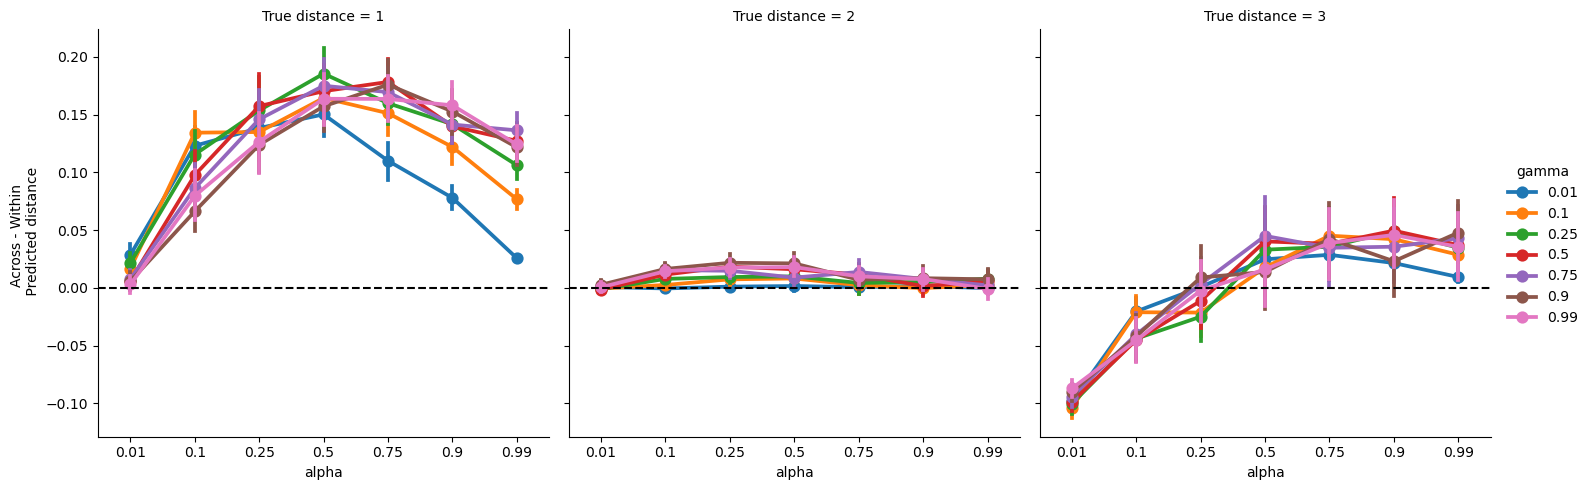

In [ ]:
#|label: fig-distance-judgement-predictions-entropy
#|fig-cap: Distance judgments when across boundary pairs are scaled by average boundary entropies and within cluster pairs are scaled by average within cluster entropy
distances = pd.read_csv('simulation_results/2moduledist_SR_distances_entropyboost.csv').drop(['Unnamed: 0', "walk_length", "model", "node"], axis = 1)
distances.rename(columns={"entropy distance (2)": "2", "entropy distance (3)": "3", "entropy distance (1)": "1"}, inplace = True)

# # distances['param_a'] = distances.param_b.astype('category')
distances['param_b'] = distances.param_b.astype('category')
distances_melt = distances.melt(id_vars=["iteration", "param_a", "param_b"], 
                                var_name= ["True distance"],
                                value_vars=["1", "2", "3"], 
                                value_name="distance_diff").reset_index(drop = True)
distances_melt.rename(columns={"param_a": "alpha", "param_b": "gamma"}, inplace = True)

g = sns.catplot(hue = 'gamma', y = 'distance_diff', x = 'alpha', col = 'True distance', 
            kind = 'point', 
            data = distances_melt)
g.axes[0][0].set_ylabel("Across - Within \n Predicted distance")

g.axes[0][0].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][1].axhline(y = 0, color = 'black', ls = '--')
g.axes[0][2].axhline(y = 0, color = 'black', ls = '--')


## Entropy based memory boost in encoding boundaries

In [ ]:
encoding_boost_df = pd.read_csv('simulation_results/3module_entropyboost.csv').drop(['Unnamed: 0'], axis = 1)

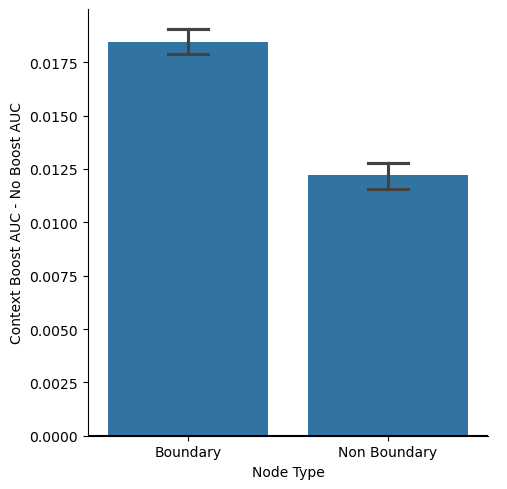

In [ ]:
#| label: fig-predicted-auc-diff-boundaryvsnonboundary
#| fig-cap: > 
#|    The Difference between AUC for recognition memory is higher for Boundary nodes than non-boundary nodes depending on context boost 
#|    indicating that boundary nodes should be remembered better.

encoding_boost_df_cb = encoding_boost_df.loc[encoding_boost_df['context boost'] == 'Boost'].reset_index(drop=True)
encoding_boost_df_ncb = encoding_boost_df.loc[encoding_boost_df['context boost'] == 'No Boost'].reset_index(drop=True)

encoding_boost_df_cb['auc diff'] = encoding_boost_df_cb['aucs'] - encoding_boost_df_ncb['aucs']
# encoding_boost_df_cb
g = sns.catplot(y = 'auc diff', x = 'Node Type', 
           kind = 'bar', capsize = 0.2, 
           data = encoding_boost_df_cb)
g.ax.set_ylabel('Context Boost AUC - No Boost AUC')
g.ax.axhline(y = 0, color = 'black')

# Implicit event boundaries focus on categorization

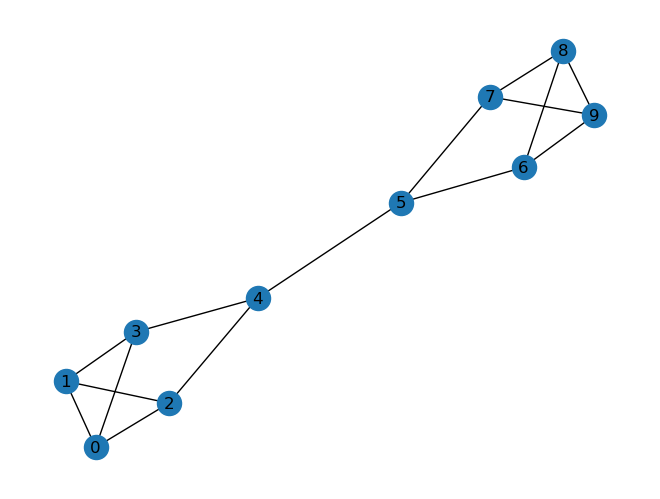

In [ ]:
#| label: fig-categorization-graph-structure
#| fig-cap: >
#|    Graph structure used in categorization tasks.
two_module_cat_graph = create_adjacency_matrix_for_modular_graph(10, 2, [5, 5], [(4, 5)], [4, 5], 
                                                                  [(0, 4), (4, 1), (2, 3),
                                                                   (9, 5), (5, 8), (6, 7)
                                                                  ])
plot_graph(two_module_cat_graph)
two_module_cat8_graph = create_adjacency_matrix_for_modular_graph(8, 2, [4, 4], [[3, 4]], [3, 4], [(3, 0), (4, 7)])
# plot_graph(two_module_cat8_graph)

In [ ]:
cat_df = pd.read_csv('simulation_results/2module_cat.csv').drop(['Unnamed: 0'], axis = 1)

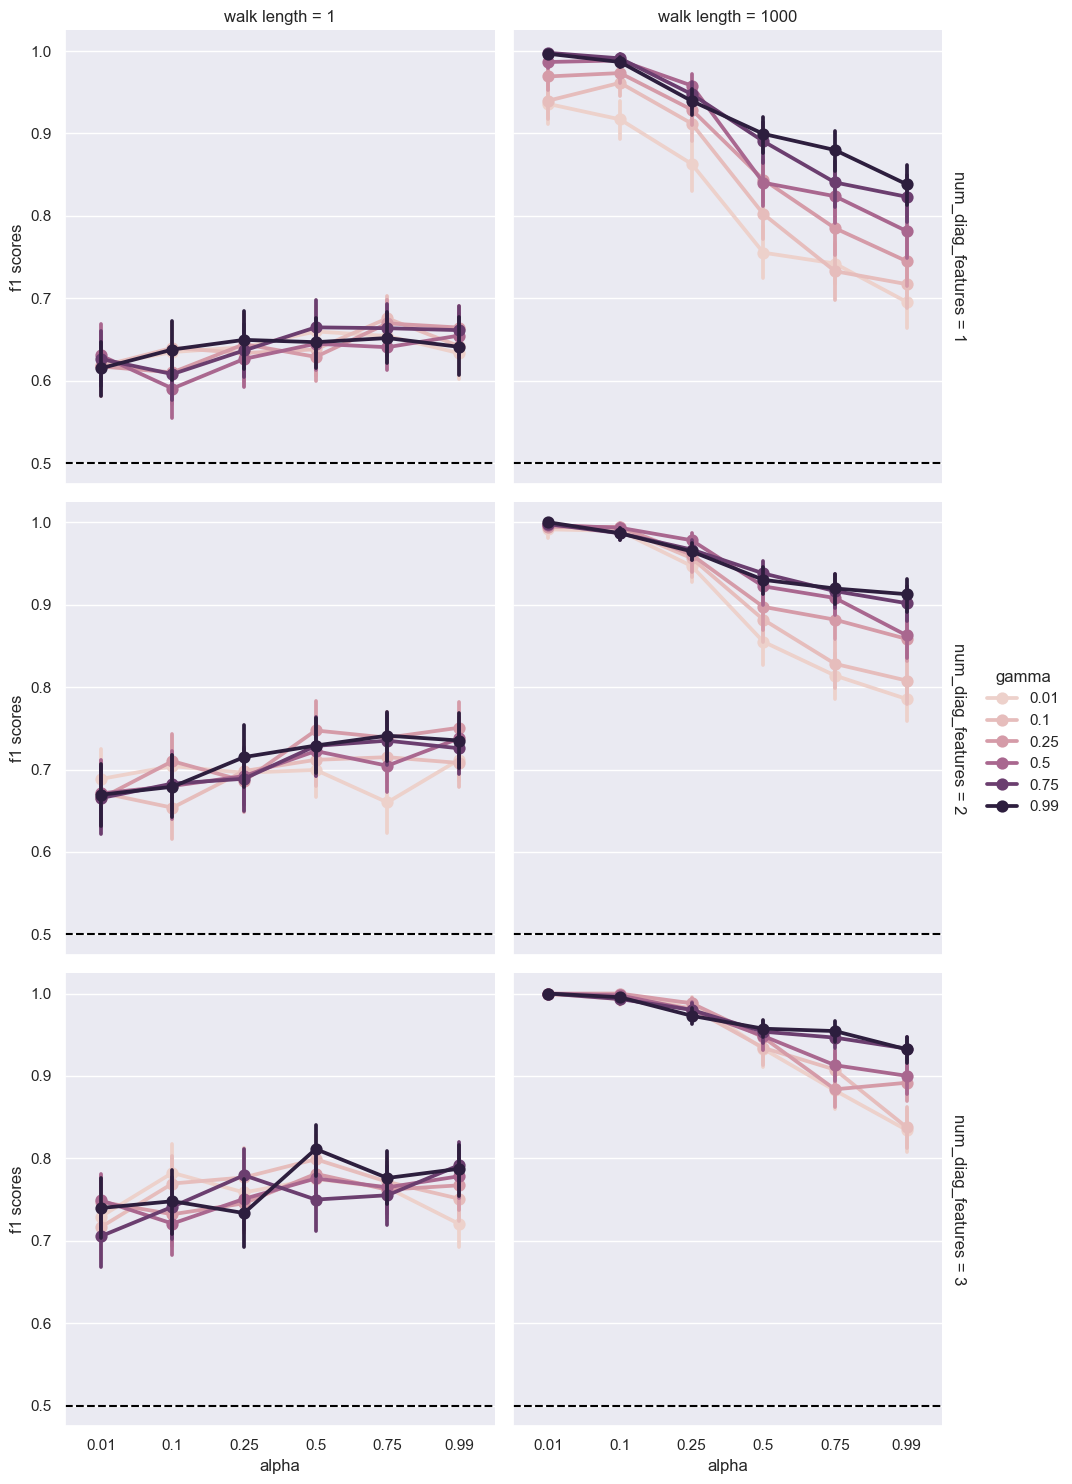

In [ ]:
#| label: fig-predicted-f1scores-categorization
#| fig-cap: >
#|    Model predicted f1 scores from categorization. 
sns.set_context('talk')
sns.set_theme()
g = sns.catplot(x = 'alpha', y = 'f1 scores', col = 'walk length', hue='gamma', row = 'num_diag_features',
            kind = 'point', margin_titles = True,
            data = cat_df)
for ax in np.ravel(g.axes):
    ax.axhline(y = 0.5, ls = '--', color = 'black')

In [ ]:
def categorization_sim(params):
    iteration = params[0]
    num_diag_features = params[1]
    walk_length = params[2]
    alpha = params[3]
    gamma = params[4]
    graph = params[5]
    if iteration%20 == 0:
        print("iteration", iteration)
    
    walk = random_walk(graph, hop_step=walk_length)
    SR = run_SR(alpha=alpha, gamma=gamma, path=walk, graph=graph, plot = True)
    SR_distances = euclidean_distances(SR)
    
    stims = np.zeros((10, 9))
    stims[:5, :num_diag_features] = 1
    stims[5:, num_diag_features:num_diag_features*2] = 1
    stims[:, num_diag_features*2:] = np.random.binomial(1, 0.5, 10*(9-num_diag_features*2)).reshape(10, 9-num_diag_features*2)
    
    for i in range(stims.shape[0]):
        stims[i] = stims[i]/np.sum(stims[i])
    
    stim_context_ass = np.dot(1-SR_distances, stims)
    gm = GaussianMixture(n_components=2, random_state=0, init_params='k-means++').fit(stim_context_ass)        
    y_ones = np.concatenate([np.ones(5), np.zeros(5)])
    y_zeros = np.concatenate([np.zeros(5), np.ones(5)])
    return stims, stim_context_ass



In [ ]:
graph = create_adjacency_matrix_for_modular_graph(10, 2, [5, 5], [(4, 5)], [4, 5], 
                                                             [(0, 4), (4, 1), (0, 2), (0, 3), 
                                                             (9, 5), (5, 8), (6, 9), (7, 9)                                                             
                                                             ])


iteration 0


Text(0.5, 22.249999999999993, 'Features')

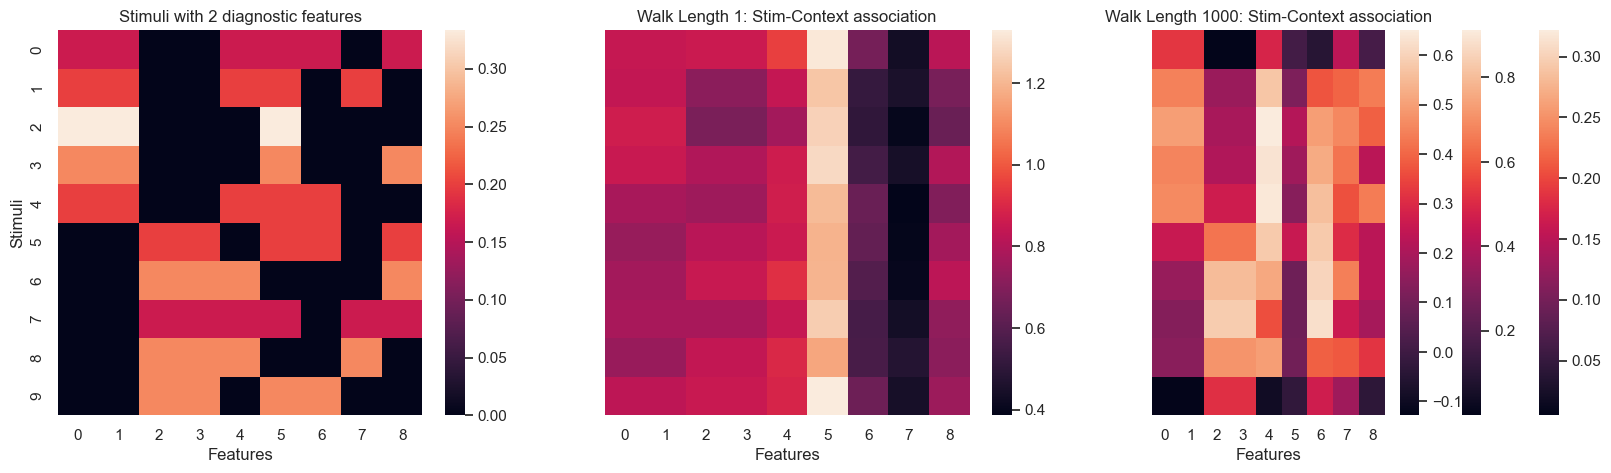

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize = (20, 5))

# SR = run_SR(walk, alpha=0.1, gamma=0.1, graph=modular_graph, plot = False)
# tcm = run_tcm(walk.astype(int), alpha=0.1, beta=0.1, graph=modular_graph, plot = False)

ax[0].set_title('Stimuli with 2 diagnostic features')
ax[1].set_title('Walk Length 1: Stim-Context association')
ax[2].set_title('Walk Length 1000: Stim-Context association')

params = [1, 2, 1, 0.1, 0.1, graph]
stims, stim_context_ass = categorization_sim(params)

sns.heatmap(stims, ax=ax[0])
sns.heatmap(stim_context_ass, ax=ax[1])
params = [1, 2, 1000, 0.1, 0.1, graph]
stims, stim_context_ass = categorization_sim(params)
sns.heatmap(stim_context_ass, ax=ax[2])

ax[0].set_ylabel('Stimuli')
ax[0].set_xlabel('Features')
ax[1].set_xlabel('Features')
ax[2].set_xlabel('Features')



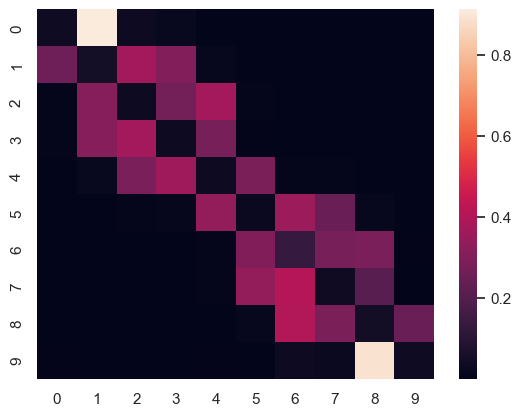

In [ ]:
walk_length = 1000
alpha = 0.1
gamma = 0.1
walk = random_walk(graph, hop_step=walk_length)
SR = run_SR(alpha=alpha, gamma=gamma, path=walk, graph=graph, plot = True)


Text(0.5, 1.0, '1 - SR Distance')

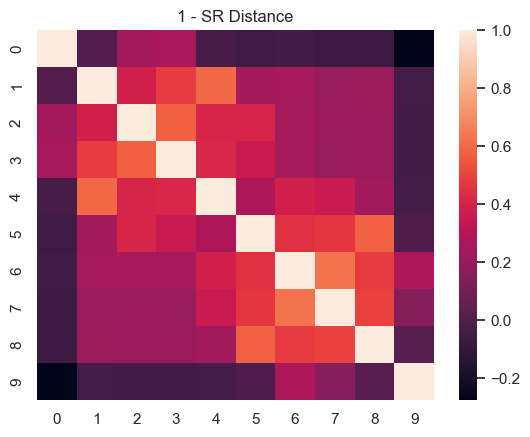

In [ ]:
sns.heatmap(1 - euclidean_distances(SR))
plt.title('1 - SR Distance')


In [ ]:
SR, SR_step = run_SR(walk, modular_graph, snapshot_step = 20)

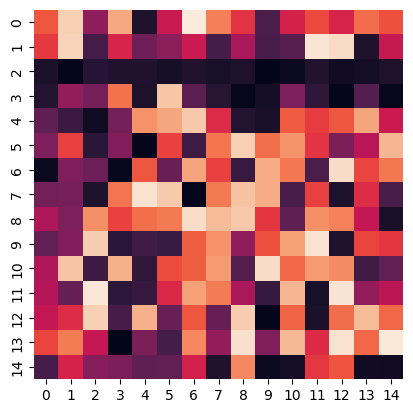

In [ ]:
def init():
      sns.heatmap(np.zeros((15, 15)), square=True, cbar=False)

def animate(i):

    data = SR_step[i]
    fig.clear()
    sns.heatmap(data, square=True, cbar=False)


fig = plt.figure()
sns.heatmap(SR)
anim = animation.FuncAnimation(fig, animate, frames=50, interval = 300, repeat=False)
anim.save('temp.gif')



In [ ]:
nonb_nonb_idx = [i for i in itertools.combinations([1, 2, 3], 2)] + [i for i in itertools.combinations([6, 7, 8], 2)] + [i for i in itertools.combinations([11, 12, 13], 2)]

In [ ]:
def compute_node_surprisal(params):
    #params is three parameters. a (alpha_SR, alpha_tcm), b(gamma, beta), hop_step
    if params[0]%10 == 0:
        print("iteration: ", params[0])
    a = params[1]
    b = params[2]
    graph = params[4]
    model = params[5]
    node_entropy = np.zeros(graph.shape[0])
    if model == 'SR':
        context_matrix, c = run_SR(random_walk(graph, hop_step=params[3]), graph, a, b, plot=False)
    else:
        context_matrix = run_tcm(random_walk(graph, hop_step=params[3]).astype(int), graph, a, b, plot=False)

    # node_surprisal = np.array([[jensenshannon(i, j) for i in context_matrix] for j in context_matrix]).reshape(15, 15)            
    # graph_entropy = -np.sum(SR*np.log(SR))
    # for node in range(graph.shape[0]):
    #     node_entropy[node] = -np.sum(context_matrix[node]*np.log(context_matrix[node]))
    nonb_nonb_idx = [i for i in itertools.combinations([1, 2, 3], 2)] + [i for i in itertools.combinations([6, 7, 8], 2)] + [i for i in itertools.combinations([11, 12, 13], 2)]
    nonb_b_idx = [i for i in itertools.product([0, 4], [1, 2, 3])] + [i for i in itertools.product([5, 9], [6, 7, 8])] + [i for i in itertools.product([10, 14], [11, 12, 13])]
    # print(context_matrix)
    nonb_nonb_js = np.mean([-np.log(context_matrix[i[0], i[1]]) for i in nonb_nonb_idx])
    nonb_b_js = np.mean([-np.log(context_matrix[i[0], i[1]]) for i in nonb_b_idx])
    b_b_js = np.mean([-np.log(context_matrix[i[0], i[1]]) for i in [(0, 14), (4, 5), (9, 10)]])

    return np.array([nonb_nonb_js, nonb_b_js, b_b_js])


In [ ]:
compute_node_surprisal([0, 0.1, 0.1, 1000, modular_graph, 'SR'])

iteration:  0


array([1.8592, 1.598 , 1.2926])

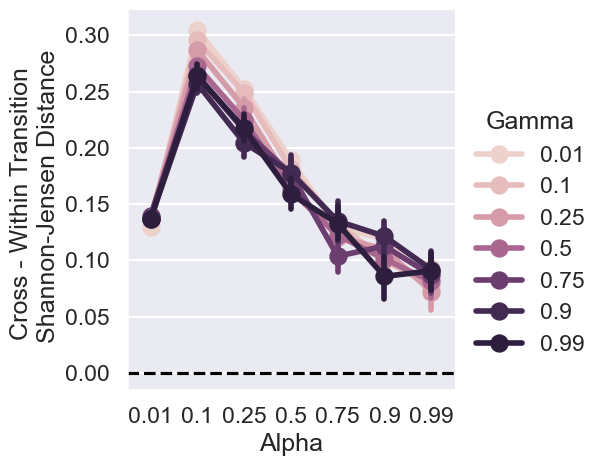

In [ ]:
df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm_sjdist.csv').drop(['Unnamed: 0'], axis = 1)
df_bb = df.loc[df['node comp'] == 'bb'].reset_index(drop=True)
df_nonbb = df.loc[df['node comp'] != 'bb'].reset_index(drop=True).groupby(['iteration', 'param_a', 'param_b', 'walk_length', 'model']).mean(numeric_only=True).reset_index(drop=True)

# df_nonboundary = df_grouped.loc[df_grouped['node_type'] == 'nonboundary'].reset_index(drop=True)
# df_boundary = df_grouped.loc[df_grouped['node_type'] == 'boundary'].reset_index(drop=True)
# df_boundary = df_boundary['entropy'] - df_nonboundary['entropy']
df_bb['entropy_diff'] = df_bb['entropy']-df_nonbb['entropy']
g = sns.catplot(x = 'param_a', y = 'entropy_diff', hue = 'param_b', #col = 'walk_length',
                data = df_bb.loc[((df_bb.model == 'SR') & (df_bb.walk_length == 1000))], kind = 'point', margin_titles=True, legend = 'full'
                # hue_order = df['param_b'].unique()
               )

ax = g.axes
for i in np.ravel(ax):
    i.axhline(y = 0, color = 'black', ls = '--')
    i.set_xlabel('Alpha')
    i.set_title('')
g.legend.set_title('Gamma')
g.set_ylabels('Cross - Within Transition \n Shannon-Jensen Distance')

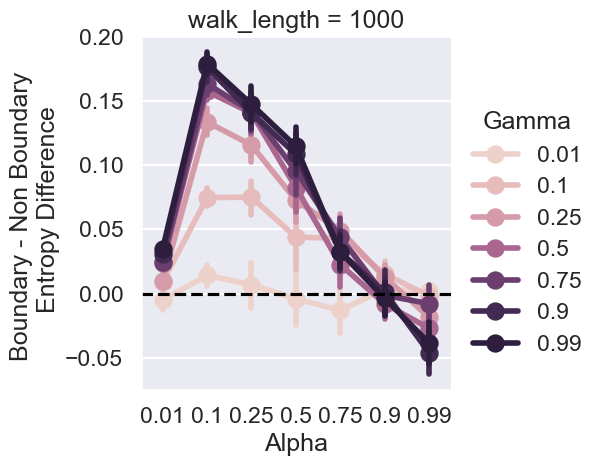

In [ ]:
df = pd.read_csv('simulation_results/3module_SRTCM_comp_simplertcm.csv').drop(['Unnamed: 0'], axis = 1)

df['node_type'] = 'nonboundary'
df.loc[df['node'].isin([0, 4, 5, 9, 10, 14]), 'node_type'] = 'boundary'
df_grouped = df.groupby(['iteration', 'param_a', 'param_b', 'walk_length', 'model', 'node_type']).mean().reset_index()
df_boundary = df_grouped.loc[df_grouped['node_type'] == 'boundary'].reset_index(drop=True)
df_nonboundary = df_grouped.loc[df_grouped['node_type'] == 'nonboundary'].reset_index(drop=True)

df_diff = df_boundary
df_diff['entropy_difference'] = df_boundary['entropy'] - df_nonboundary['entropy']
df_diff = df_diff.drop(['entropy', 'node_type'], axis = 1)


g = sns.catplot(x = 'param_a', y = 'entropy_difference', hue = 'param_b', col = 'walk_length',
                data = df_diff.loc[((df_diff.model == 'SR') & (df_diff.walk_length == 1000))], kind = 'point', margin_titles=True, legend = 'full'
                # hue_order = df_diff['param_b'].unique()
               )
ax = g.axes
for i in np.ravel(ax):
    i.axhline(y = 0, color = 'black', ls = '--')
    i.set_xlabel('Alpha')
g.legend.set_title('Gamma')
g.set_ylabels('Boundary - Non Boundary \n Entropy Difference')
# g.set_ylabels('Boundary - Non Boundary node \n Entropy Difference')

In [ ]:
# -np.log(0.1), -np.log(0.5)

(2.3025850929940455, 0.6931471805599453)